In [ ]:
# !pip install -q wandb
! pip install -q kaggle
# !pip install ultralytics

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import cv2
import natsort
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import wandb

In [ ]:
config = {
    "BATCH_SIZE": 16,
    "EPOCHS": 500,
    "PATIENT": 35,
    "LR": 0.001,
    "IN_CHANEL": 3,
    "OUT_CHANNEL": 2,
    "P_TRANSFORM": 0.5,
    "THRESHOLD": 0.5,
    "PATH_OUT_MODEL": f"Unet-NET_b32_e500_p35_lr0.001_i3_o2.pth"
}

config

{'BATCH_SIZE': 16,
 'EPOCHS': 500,
 'PATIENT': 35,
 'LR': 0.001,
 'IN_CHANEL': 3,
 'OUT_CHANNEL': 2,
 'P_TRANSFORM': 0.5,
 'THRESHOLD': 0.5,
 'PATH_OUT_MODEL': 'Unet-NET_b32_e500_p35_lr0.001_i3_o2.pth'}

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="38-Cloud", name=config['PATH_OUT_MODEL'], config=config)

## Download dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
mkdir ~/.kaggle

In [ ]:
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download sorour/38cloud-cloud-segmentation-in-satellite-images

Dataset URL: https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images
License(s): unknown
100% 12.2G/12.2G [09:03<00:00, 26.3MB/s]
100% 12.2G/12.2G [09:03<00:00, 24.0MB/s]


In [ ]:
# ! kaggle datasets download sorour/95cloud-cloud-segmentation-on-satellite-images

In [ ]:
!mkdir /content/38-cloud
!unzip 38cloud-cloud-segmentation-in-satellite-images.zip -d /content/38-cloud
!rm -rf 38cloud-cloud-segmentation-in-satellite-images.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_12_by_7_LC08_L1TP_011002_20160620_20170323_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_011247_20160620_20170323_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_029040_20160720_20170222_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_032029_20160420_20170223_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_034034_20160520_20170223_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_045026_20160720_20170221_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud_training/train_red/red_patch_271_13_by_19_LC08_L1TP_047023_20160920_20170221_01_T1.TIF  
  inflating: /content/38-cloud/38-Cloud

In [ ]:
# !mkdir /content/95-cloud
# !unzip 95cloud-cloud-segmentation-on-satellite-images.zip -d /content/95-cloud
# !rm -rf 95cloud-cloud-segmentation-on-satellite-images.zip

## Dataset

In [ ]:
def remove_images_with_high_black_percentage(dataset, plot_black_images=False, threshold = 0.8):
    new_files = []
    total_images = len(dataset)


    for idx in range(total_images):
        file = dataset.files[idx]
        black_percentage = calculate_black_percentage(file)

        if not (black_percentage['red'] > threshold and black_percentage['green'] > threshold and black_percentage['blue'] > threshold):
            new_files.append(file)
        elif plot_black_images:
            print("Image with high black percentage found, plotting...")
            plot_image(file)

    dataset.files = new_files

def calculate_black_percentage(file):
    black_percentage = {}
    for band in ['red', 'green', 'blue']:
        image = np.array(Image.open(file[band]))
        total_pixels = image.shape[0] * image.shape[1]
        black_pixels = np.count_nonzero(image == 0)
        black_percentage[band] = black_pixels / total_pixels
    return black_percentage

def plot_image(file):
    fig, axes = plt.subplots(1, len(file), figsize=(15, 5))
    for i, (band, ax) in enumerate(zip(file.keys(), axes)):
        image = np.array(Image.open(file[band]))
        ax.imshow(image)
        ax.set_title(band)
        ax.axis('off')
    plt.show()

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, transform=None):
        super().__init__()

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(
            f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.transform = transform

    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):

        files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

    def __len__(self):

        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                            ], axis=2)

        if include_nir:
            nir = np.expand_dims(
                np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))

        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def open_mask(self, idx, add_dims=False):

        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):

        x = torch.tensor(self.open_as_array(
            idx, invert=self.pytorch, include_nir=False), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False),
                         dtype=torch.torch.int64)

        if self.transform:
            x = x.permute(1,2,0)
            augmented = self.transform(image=x.numpy(), mask=y.numpy())
            x = augmented['image']
            y = augmented['mask']
        return x, y

In [ ]:
p_transform = config['P_TRANSFORM']
transform = A.Compose([
            A.HorizontalFlip(p=p_transform),
            A.VerticalFlip(p=p_transform),
            A.RandomRotate90(p=p_transform),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=p_transform),
            A.RandomBrightnessContrast(p=p_transform),
            ToTensorV2(p=1.0),
        ], p=1.0)


In [ ]:
try:
  base_path = Path('/content/95-cloud/95-cloud_training_only_additional_to38-cloud')
  data = CloudDataset(base_path/'train_red_additional_to38cloud',
                      base_path/'train_green_additional_to38cloud',
                      base_path/'train_blue_additional_to38cloud',
                      base_path/'train_nir_additional_to38cloud',
                      base_path/'train_gt_additional_to38cloud',
                      # transform=transform
                      )

  # remove_images_with_high_black_percentage(data, plot_black_images=True)
  # remove_images_with_high_black_percentage(data)
  len(data)
except:
  pass

In [ ]:
try:
  base_path = Path('/content/38-cloud/38-Cloud_training')
  data = CloudDataset(base_path/'train_red',
                      base_path/'train_green',
                      base_path/'train_blue',
                      base_path/'train_nir',
                      base_path/'train_gt',
                      # transform=transform
                      )

  # remove_images_with_high_black_percentage(data, plot_black_images=True)
  # remove_images_with_high_black_percentage(data)
  len(data)
except:
  pass

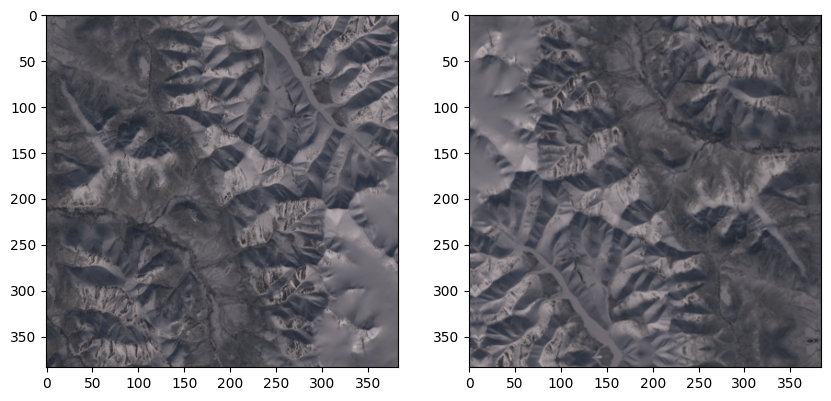

In [ ]:
dataiter = data[10]
img_transormed = transform(image=dataiter[0].permute(1, 2, 0).numpy(), mask=dataiter[1].numpy())
img_transormed = img_transormed['image']
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataiter[0].permute(1, 2, 0))
ax[1].imshow(img_transormed.permute(1, 2, 0))
plt.show()


In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [ ]:
x, y = data[10]
x.shape, y.shape


(torch.Size([3, 384, 384]), torch.Size([384, 384]))

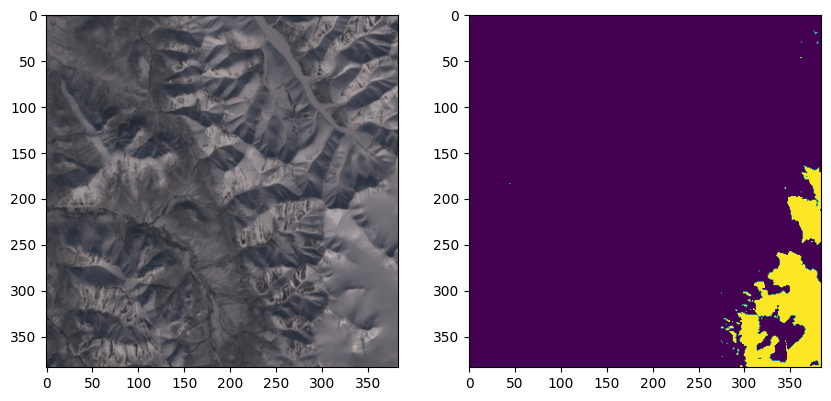

In [ ]:
# visualize raw image and ground truth
image_index = 10

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))


In [ ]:
calculate_black_percentage(data.files[1000])

{'red': 1.0, 'green': 1.0, 'blue': 1.0}

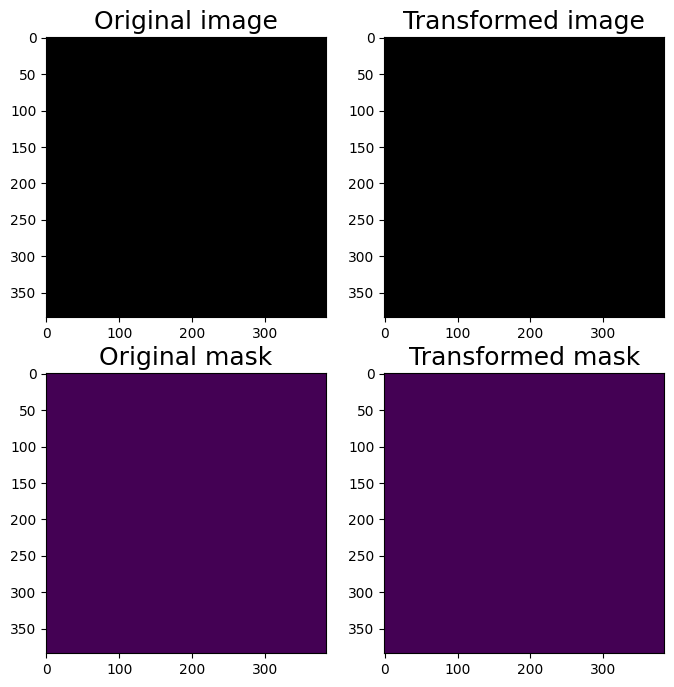

In [ ]:
xb, yb = data[1000]

# visualize augmented images and masks
visualize(xb.permute(1,2,0).numpy(), yb.numpy(), original_image=data.open_as_array(1000), original_mask=data.open_mask(1000))

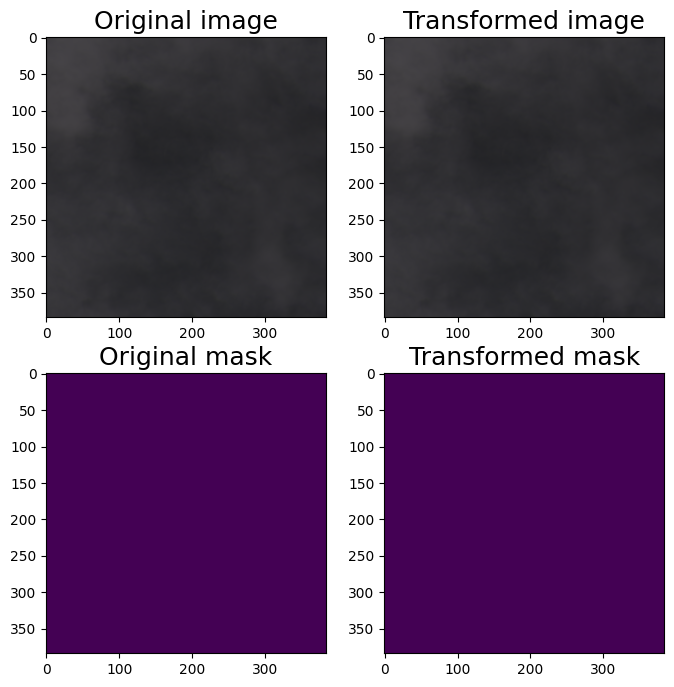

In [ ]:
idx = 102
xb, yb = data[idx]

# visualize augmented images and masks
visualize(xb.permute(1,2,0).numpy(), yb.numpy(), original_image=data.open_as_array(idx), original_mask=data.open_mask(idx))

In [ ]:
import math

train_dataset, valid_dataset = torch.utils.data.random_split(
    data, (int(math.ceil(len(data)*0.7)), int(len(data)*0.3)))

train_dataload = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataload = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [ ]:
len(data), len(train_dataset), len(valid_dataset)

(8400, 5880, 2520)

## Dataset cloudnet

In [ ]:
files_in_validation_set = [valid_dataset.dataset.files[i] for i in valid_dataset.indices]

In [ ]:
files_in_validation_set = [valid_dataset.dataset.files[10]]

In [ ]:
import shutil
import pandas as pd
from pathlib import Path
import os

df = pd.DataFrame(columns=['name'])
destination = Path("/content/data/teste")
if not (destination.exists()):
  destination.mkdir(parents=True)

for file in files_in_validation_set:
    for band in file.keys():
        if 'red' in band:
            patch_name = str(file[band]).split('red_')[-1]
            patch_name = patch_name.split('.TIF')[0]
            df.loc[len(df)] = patch_name
        if not (destination/f'test_{band}').exists():
            (destination/f'test_{band}').mkdir(parents=True)
        shutil.copy(file[band], destination/f'test_{band}')

df.to_csv(destination/'test.csv', index=False)

## Dataset yolo

In [ ]:
import cv2
from PIL import Image

def save_images(dataset, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_dir+"/mask", exist_ok=True)

    for idx in range(len(dataset)):
        x, y = dataset[idx]

        # Save images as PNG and RGB
        image_name = os.path.join(output_dir, f"image_{idx}.png")
        mask_name = os.path.join(output_dir,'mask', f"image_{idx}.png")

        # Save image
        x_to_save = x.permute(1, 2, 0).numpy() * 255
        x_to_save = x_to_save.astype(np.uint8)
        Image.fromarray(x_to_save).save(image_name)

        # Save mask
        y_to_save = y.squeeze().numpy() * 255
        y_to_save = y_to_save.astype(np.uint8)
        Image.fromarray(y_to_save).save(mask_name)


def mask2poligon(input_dir,output_dir):
  os.makedirs(output_dir, exist_ok=True)

  for j in os.listdir(input_dir):
      image_path = os.path.join(input_dir, j)
      # load the binary mask and get its contours
      mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

      H, W = mask.shape
      contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # convert the contours to polygons
      polygons = []
      for cnt in contours:
          if cv2.contourArea(cnt) > 200:
              polygon = []
              for point in cnt:
                  x, y = point[0]
                  polygon.append(x / W)
                  polygon.append(y / H)
              polygons.append(polygon)

      # print the polygons
      with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
          for polygon in polygons:
              for p_, p in enumerate(polygon):
                  if p_ == len(polygon) - 1:
                      f.write('{}\n'.format(p))
                  elif p_ == 0:
                      f.write('0 {} '.format(p))
                  else:
                      f.write('{} '.format(p))

          f.close()

In [ ]:

# output_dir = "/content/yolo/images/train"
# save_images(train_dataset, output_dir)


output_dir = "/content/yolo/images/val"
save_images(valid_dataset, output_dir)


In [ ]:
# input_dir = "/content/yolo/images/train/mask"
# output_dir = "/content/yolo/labels/train/"
# mask2poligon(input_dir,output_dir)

In [ ]:
input_dir = "/content/yolo/images/val/mask"
output_dir = "/content/yolo/labels/val/"
mask2poligon(input_dir,output_dir)

In [ ]:
# # prompt: move all txt in file to other file
# !mkdir /content/yolo/labels/train/
# !mkdir /content/yolo/labels/val/
# !mv /content/yolo/images/train/*.txt /content/yolo/labels/train/
# !mv /content/yolo/images/val/*.txt /content/yolo/labels/val/


## Train Yolo

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt')

# Train the model
results = model.train(data='/content/config.yaml',epochs=150, imgsz=384, patience=50, device=0, batch=config['BATCH_SIZE'])

100%|██████████| 6.73M/6.73M [00:00<00:00, 93.3MB/s]


Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/config.yaml, epochs=150, time=None, patience=50, batch=16, imgsz=384, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 123MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo/labels/train... 3609 images, 4227 backgrounds, 0 corrupt: 100%|██████████| 7218/7218 [00:10<00:00, 717.30it/s] 


train: New cache created: /content/yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo/labels/val... 1546 images, 1806 backgrounds, 0 corrupt: 100%|██████████| 3092/3092 [00:04<00:00, 676.99it/s] 


val: New cache created: /content/yolo/labels/val.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.22G       1.23       2.72      2.021      1.241         15        384: 100%|██████████| 452/452 [02:11<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.74it/s]


                   all       3092       6587      0.633      0.588      0.576      0.352      0.647      0.584      0.577       0.32

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.35G      1.183      2.382      1.463      1.194          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.80it/s]


                   all       3092       6587      0.639       0.54      0.552      0.323      0.645      0.532      0.544      0.275

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.28G      1.267      2.409      1.467      1.235          1        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.516      0.478      0.449      0.242      0.523      0.458      0.433      0.205

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.29G      1.307      2.481      1.447      1.258          3        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.91it/s]


                   all       3092       6587      0.539      0.473      0.468      0.248       0.55      0.475      0.465      0.223

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.25G       1.27      2.389      1.347      1.243          9        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.88it/s]


                   all       3092       6587      0.534       0.46      0.466      0.243      0.549      0.452      0.463      0.209

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.27G      1.246      2.317      1.292      1.223          9        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.85it/s]


                   all       3092       6587      0.623      0.548      0.588       0.34      0.632      0.546      0.587       0.31

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.28G      1.219      2.282       1.25      1.207          2        384: 100%|██████████| 452/452 [02:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.80it/s]


                   all       3092       6587       0.55       0.37      0.399      0.241      0.561      0.369      0.401      0.214

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/150       1.3G      1.198      2.321      1.227      1.209          3        384: 100%|██████████| 452/452 [01:59<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.87it/s]


                   all       3092       6587      0.706      0.591      0.646      0.402      0.707      0.593       0.64       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.26G      1.202      2.237      1.192      1.203         11        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.86it/s]


                   all       3092       6587      0.682       0.61      0.627      0.389      0.678      0.606      0.622      0.345

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.23G      1.169      2.187      1.145      1.187          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.87it/s]


                   all       3092       6587      0.711      0.616      0.646      0.408      0.717      0.617      0.646      0.368

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.33G      1.151      2.146      1.138       1.18          9        384: 100%|██████████| 452/452 [01:59<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.86it/s]


                   all       3092       6587      0.628      0.557      0.543      0.342      0.631      0.542      0.533      0.294

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.28G      1.156      2.151      1.144      1.187          1        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.85it/s]


                   all       3092       6587      0.671      0.611      0.599      0.386      0.676      0.616      0.598      0.349

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.24G      1.135      2.131      1.111      1.175          9        384: 100%|██████████| 452/452 [02:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.98it/s]


                   all       3092       6587      0.558      0.551      0.471      0.288       0.56      0.548      0.463      0.245

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.25G       1.13       2.11      1.099      1.167          2        384: 100%|██████████| 452/452 [01:59<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.91it/s]


                   all       3092       6587      0.726      0.616      0.691      0.456       0.73      0.617      0.686      0.408

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.25G      1.129      2.104      1.081      1.167          2        384: 100%|██████████| 452/452 [01:59<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.98it/s]


                   all       3092       6587      0.731      0.644      0.695      0.448      0.743      0.651      0.696      0.407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.23G       1.11      2.099      1.077      1.163          8        384: 100%|██████████| 452/452 [01:59<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


                   all       3092       6587      0.735       0.64      0.681      0.461      0.737      0.644      0.676      0.406

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.27G      1.115      2.057      1.072      1.155          2        384: 100%|██████████| 452/452 [01:59<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.706       0.61      0.663      0.422      0.714      0.606      0.658      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.29G      1.117      2.094      1.076      1.168         14        384: 100%|██████████| 452/452 [01:58<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.624      0.492      0.474      0.311      0.621      0.488      0.461      0.269

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/150       1.3G       1.09      2.066      1.044      1.154          2        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.84it/s]


                   all       3092       6587      0.719      0.633      0.692       0.47       0.72      0.634      0.683      0.404

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.25G      1.089      2.049      1.055      1.159          3        384: 100%|██████████| 452/452 [02:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.87it/s]


                   all       3092       6587        0.7      0.628      0.677      0.452      0.709      0.627      0.675      0.407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.29G      1.097      2.078      1.057      1.159          2        384: 100%|██████████| 452/452 [02:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.694      0.634      0.676      0.457      0.693      0.632      0.666      0.402

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.25G      1.075      2.046      1.045      1.143          1        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.11it/s]


                   all       3092       6587      0.729      0.642      0.691      0.458      0.734      0.635      0.681      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.23G      1.086      2.035      1.035      1.145          7        384: 100%|██████████| 452/452 [01:59<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.04it/s]


                   all       3092       6587      0.755      0.653      0.723       0.48       0.76      0.654      0.719      0.423

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.23G      1.085      2.033       1.04      1.146          2        384: 100%|██████████| 452/452 [01:58<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.732      0.642      0.712      0.482      0.737      0.642      0.706      0.431

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.23G       1.08      2.006      1.041      1.141          0        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.743       0.65      0.714      0.483      0.745      0.642      0.702      0.423

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.26G      1.076       2.02       1.02      1.147          8        384: 100%|██████████| 452/452 [02:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.90it/s]


                   all       3092       6587      0.751      0.644      0.696      0.467      0.755      0.643      0.692      0.409

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.25G      1.052      1.973     0.9937      1.139          5        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.03it/s]


                   all       3092       6587      0.735       0.64      0.702      0.464      0.744      0.639      0.697      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.26G      1.043      1.978      1.004      1.136          8        384: 100%|██████████| 452/452 [02:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.19it/s]


                   all       3092       6587       0.74      0.652      0.727       0.49       0.76      0.639      0.719      0.429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.22G      1.045      1.965     0.9949       1.13          6        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.743      0.655      0.717      0.491      0.749      0.652      0.711      0.434

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.22G      1.039      1.941     0.9898      1.134         11        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.82it/s]


                   all       3092       6587      0.752      0.647      0.729        0.5      0.763       0.64      0.716      0.441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.24G      1.044      1.974     0.9913      1.128          7        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.717      0.634      0.674      0.455      0.715      0.631      0.661      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.25G      1.038      1.958      0.983       1.13          4        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.82it/s]


                   all       3092       6587      0.758      0.668      0.741      0.498      0.769      0.661      0.736      0.437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.22G      1.054      1.982     0.9835       1.13         19        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.81it/s]


                   all       3092       6587      0.767      0.657      0.739       0.51      0.778      0.654      0.732      0.446

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.22G      1.037       1.96     0.9844      1.129          7        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.78it/s]


                   all       3092       6587      0.691      0.647      0.598      0.404      0.693      0.644      0.594      0.358

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.26G      1.031      1.944     0.9682      1.128          5        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.81it/s]


                   all       3092       6587      0.706      0.658      0.681      0.468      0.711      0.655      0.679      0.412

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.28G      1.029      1.996     0.9781      1.126          4        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.95it/s]


                   all       3092       6587      0.744      0.645      0.717      0.472      0.746      0.642      0.711      0.414

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.24G      1.033      1.966     0.9876      1.125          1        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.755      0.672      0.741      0.504      0.763       0.66       0.73       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.22G      1.031      1.961     0.9834      1.124         19        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.85it/s]


                   all       3092       6587      0.761       0.68      0.751      0.518      0.766      0.677      0.741       0.45

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.24G      1.016      1.941     0.9699      1.123          3        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


                   all       3092       6587       0.76      0.662      0.749      0.516      0.772      0.658      0.743       0.45

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/150       1.2G      1.017      1.908     0.9592      1.119          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.768      0.661      0.751      0.523       0.77      0.662      0.742      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.22G      1.016      1.918     0.9639      1.122          5        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.88it/s]


                   all       3092       6587      0.769      0.666      0.731      0.504       0.77      0.669      0.729      0.445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.23G      1.032      1.933     0.9705      1.122         19        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.01it/s]


                   all       3092       6587      0.724      0.654       0.69      0.473      0.728      0.649      0.681      0.415

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.23G      1.012      1.914     0.9509      1.119          2        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


                   all       3092       6587      0.771      0.664      0.751      0.523      0.773       0.66      0.739      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.24G      1.014       1.93     0.9553      1.121          8        384: 100%|██████████| 452/452 [02:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.87it/s]


                   all       3092       6587      0.695      0.641      0.659      0.445      0.699      0.634      0.649      0.384

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.24G      1.012      1.926     0.9491      1.113         17        384: 100%|██████████| 452/452 [02:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.04it/s]


                   all       3092       6587      0.735      0.669      0.744      0.519      0.736      0.662      0.729      0.447

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.22G      1.022      1.914     0.9828       1.12          0        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


                   all       3092       6587      0.757      0.664       0.75      0.518      0.765      0.661      0.743      0.453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.22G      1.013      1.909     0.9564      1.116         10        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.94it/s]


                   all       3092       6587      0.775       0.65      0.753      0.521      0.776       0.65      0.741      0.449

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.24G      1.007      1.898     0.9356      1.109         12        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.763      0.676      0.756      0.529      0.765      0.675      0.746      0.452

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.21G      1.015      1.935     0.9451      1.119          2        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.90it/s]


                   all       3092       6587       0.77      0.662      0.752      0.521      0.774      0.658      0.741      0.454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.22G     0.9939      1.875     0.9452      1.112          0        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.89it/s]


                   all       3092       6587       0.77      0.668      0.752      0.523       0.78      0.664      0.745      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.24G      1.004      1.885     0.9391      1.112          7        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.04it/s]


                   all       3092       6587      0.764      0.669      0.755       0.53      0.768      0.666      0.747      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.22G      1.001      1.885     0.9506      1.111          7        384: 100%|██████████| 452/452 [01:59<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.00it/s]


                   all       3092       6587      0.748      0.657      0.747      0.528       0.75      0.654      0.736      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.21G     0.9927      1.866     0.9352      1.104          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.01it/s]


                   all       3092       6587       0.79      0.663      0.762      0.534      0.792      0.664      0.755      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.22G          1      1.906     0.9276      1.106          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.732      0.674      0.715      0.506      0.733      0.666      0.703      0.436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/150       1.3G      1.001      1.866     0.9203      1.102          7        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.88it/s]


                   all       3092       6587      0.772      0.677      0.759      0.531      0.773      0.677      0.752      0.467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.23G     0.9933      1.862     0.9209      1.105          2        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.88it/s]


                   all       3092       6587      0.721      0.661      0.685      0.477      0.722      0.659      0.675      0.409

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.22G     0.9921       1.88     0.9161      1.103          4        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.92it/s]


                   all       3092       6587      0.763      0.671      0.756      0.531      0.763      0.666      0.744      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.26G     0.9792      1.853     0.9122      1.102          2        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


                   all       3092       6587      0.766      0.681      0.762      0.536      0.773      0.677      0.753       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.22G     0.9756      1.849     0.9023      1.101         16        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.28it/s]


                   all       3092       6587      0.787      0.678      0.771      0.541      0.788      0.677       0.76      0.472

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.25G     0.9959      1.889     0.9291      1.105          5        384: 100%|██████████| 452/452 [02:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.734      0.668      0.727       0.51       0.74      0.663      0.719      0.445

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.22G     0.9623      1.838     0.9056      1.096          6        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.781      0.671      0.765      0.538      0.787      0.671      0.759      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.24G     0.9713      1.849     0.9036      1.096         13        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.03it/s]


                   all       3092       6587      0.775       0.68      0.767      0.537      0.777      0.681      0.759      0.468

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.24G     0.9813       1.85     0.9046      1.096          4        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.86it/s]


                   all       3092       6587       0.78       0.67      0.766      0.539      0.789      0.667      0.758       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.24G     0.9788      1.838     0.9175      1.097          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.771      0.672      0.765      0.531      0.782      0.662      0.754      0.458

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.24G     0.9842       1.84     0.9045      1.093          3        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.89it/s]


                   all       3092       6587      0.783      0.684      0.776      0.545      0.793      0.679      0.769      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.23G     0.9647      1.816     0.8971      1.094          2        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.773      0.677      0.767       0.54      0.784       0.67      0.759       0.47

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.22G     0.9575      1.824     0.8941      1.094          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


                   all       3092       6587      0.778       0.68      0.774      0.548      0.784      0.682      0.766      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.23G     0.9682      1.822     0.8928      1.089         30        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.04it/s]


                   all       3092       6587       0.78      0.684      0.774      0.552      0.791      0.676      0.765      0.481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.22G     0.9756      1.821     0.9216      1.093          0        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.777      0.684      0.775       0.55      0.785      0.678      0.765      0.478

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/150       1.2G     0.9699       1.85     0.8997      1.097          7        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:25<00:00,  3.85it/s]


                   all       3092       6587      0.765      0.692      0.778      0.553      0.774      0.686      0.768      0.481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.24G     0.9602      1.823     0.8939      1.093          3        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


                   all       3092       6587      0.772      0.681      0.772      0.546      0.776      0.682      0.763      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.26G     0.9789      1.821     0.8996      1.099          4        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.781      0.666      0.769       0.54      0.785      0.671      0.764      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.22G     0.9683      1.831     0.8869      1.096          5        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.03it/s]


                   all       3092       6587      0.784      0.667       0.77      0.536       0.79      0.668      0.763      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.23G     0.9627      1.807     0.8869      1.087          3        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.21it/s]


                   all       3092       6587      0.772      0.675      0.769      0.536       0.77       0.68      0.762      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.22G     0.9654      1.818      0.875      1.088          8        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.21it/s]


                   all       3092       6587      0.781      0.671      0.771      0.543      0.785      0.675      0.765      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.24G     0.9582      1.818     0.8855      1.092         11        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.30it/s]


                   all       3092       6587      0.774      0.685      0.777      0.551      0.776      0.686       0.77      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.23G     0.9706      1.824      0.898      1.091          1        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.34it/s]


                   all       3092       6587      0.784      0.675      0.775      0.547      0.787      0.676      0.767      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.24G     0.9509      1.784     0.8652      1.085         24        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.07it/s]


                   all       3092       6587      0.786      0.674      0.776      0.546       0.79      0.674      0.769      0.474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.22G     0.9599       1.77     0.8709      1.082         12        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


                   all       3092       6587      0.788      0.671      0.776      0.549      0.799      0.667      0.768      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.23G     0.9607      1.807     0.8869      1.092          1        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


                   all       3092       6587      0.789      0.671      0.776      0.549      0.793      0.671      0.767      0.477

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.24G     0.9636      1.824     0.9209      1.086          0        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.22it/s]


                   all       3092       6587      0.788      0.686      0.782      0.556      0.787      0.688      0.774      0.484

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.22G     0.9528      1.812     0.8688      1.086         10        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.29it/s]


                   all       3092       6587      0.788      0.687      0.784      0.557      0.786       0.69      0.776      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.22G     0.9348      1.795     0.8686      1.086          1        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.22it/s]


                   all       3092       6587      0.785      0.689       0.78      0.555      0.788       0.69      0.775      0.485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.22G     0.9473      1.771     0.8619      1.084          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.04it/s]


                   all       3092       6587      0.789      0.683      0.779      0.552      0.802      0.674      0.771      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.21G     0.9393      1.767     0.8468      1.079         12        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


                   all       3092       6587      0.792      0.678       0.78      0.551      0.797       0.68      0.772       0.48

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/150       1.2G     0.9315       1.75     0.8535      1.074          4        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


                   all       3092       6587      0.782      0.693      0.784      0.556       0.79      0.689      0.775      0.483

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.24G     0.9504      1.797     0.8719       1.09          3        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


                   all       3092       6587      0.784       0.69      0.784      0.557      0.786      0.692      0.775      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.24G     0.9423      1.794     0.8639      1.077         11        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


                   all       3092       6587      0.776      0.694      0.781      0.554      0.779      0.697      0.771       0.48

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.22G      0.932      1.748       0.86      1.077         16        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


                   all       3092       6587      0.801      0.667      0.777      0.552      0.805       0.67       0.77      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.21G     0.9264      1.762     0.8561      1.077          1        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


                   all       3092       6587      0.773      0.692       0.78      0.554      0.786      0.684      0.771      0.484

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.26G     0.9448      1.769     0.8698      1.077          1        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


                   all       3092       6587      0.741      0.692      0.742      0.528      0.741      0.693      0.733      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.22G     0.9487      1.784     0.8577      1.083          5        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.11it/s]


                   all       3092       6587      0.752      0.673       0.72      0.505      0.757      0.671      0.712       0.44

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.24G     0.9303      1.762     0.8584      1.078          6        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


                   all       3092       6587       0.76       0.68      0.758      0.541      0.762       0.68       0.75      0.473

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.24G     0.9445      1.787     0.8596      1.081         12        384: 100%|██████████| 452/452 [02:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.32it/s]


                   all       3092       6587      0.788      0.682      0.781      0.555      0.796       0.68      0.774      0.484

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.24G     0.9213      1.764     0.8495      1.072          3        384: 100%|██████████| 452/452 [02:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.36it/s]


                   all       3092       6587      0.791      0.684      0.784      0.557      0.793      0.685      0.777      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.22G     0.9318      1.758     0.8571       1.07          0        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


                   all       3092       6587      0.795      0.685      0.786      0.559      0.795      0.688      0.777      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.22G     0.9378      1.747      0.842      1.071          5        384: 100%|██████████| 452/452 [02:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.11it/s]


                   all       3092       6587      0.792      0.688      0.785      0.559      0.791      0.692      0.778      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.22G     0.9398      1.768     0.8546      1.079          3        384: 100%|██████████| 452/452 [02:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


                   all       3092       6587      0.799      0.685      0.786       0.56      0.801      0.685      0.778       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.22G     0.9316      1.752      0.841       1.07          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


                   all       3092       6587      0.793       0.69      0.787       0.56      0.794      0.691      0.779       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.23G     0.9177      1.714     0.8363      1.067          9        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.802      0.682      0.786      0.558      0.801      0.682      0.777      0.487

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.22G       0.93      1.771     0.8522      1.077          6        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.01it/s]


                   all       3092       6587      0.803      0.681      0.785      0.557      0.807      0.682      0.777      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.22G     0.9088      1.721     0.8486      1.069          1        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.00it/s]


                   all       3092       6587      0.799      0.685      0.786       0.56      0.801      0.687      0.778      0.487

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.22G     0.9219      1.742     0.8262      1.071          4        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.13it/s]


                   all       3092       6587      0.801      0.689      0.789       0.56      0.802      0.689       0.78      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.19G     0.9068      1.727     0.8266      1.068          1        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.10it/s]


                   all       3092       6587      0.799      0.689      0.789      0.561      0.802      0.688      0.782      0.487

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/150       1.2G     0.9366      1.752     0.8431      1.074          5        384: 100%|██████████| 452/452 [02:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.10it/s]


                   all       3092       6587      0.799      0.687       0.79      0.561      0.803      0.685      0.782      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.23G     0.9187      1.725     0.8395      1.068         16        384: 100%|██████████| 452/452 [02:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.04it/s]


                   all       3092       6587      0.799      0.689       0.79      0.561      0.804      0.687      0.782      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.22G     0.9143      1.704      0.822      1.073          6        384: 100%|██████████| 452/452 [02:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.97it/s]


                   all       3092       6587      0.796      0.691      0.788      0.561      0.801       0.69      0.781      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/150       1.2G     0.9094      1.702     0.8154      1.063         10        384: 100%|██████████| 452/452 [02:07<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.20it/s]


                   all       3092       6587      0.796      0.689      0.788       0.56      0.799      0.691       0.78      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.22G     0.9164      1.732     0.8256      1.065         17        384: 100%|██████████| 452/452 [02:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


                   all       3092       6587      0.798      0.691      0.789      0.562      0.801      0.692      0.781      0.489

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.22G     0.9054      1.714     0.8178      1.063          8        384: 100%|██████████| 452/452 [02:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.04it/s]


                   all       3092       6587      0.797      0.692      0.789      0.562      0.805       0.69      0.781       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.21G      0.915      1.708     0.8229      1.066         15        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587        0.8      0.691       0.79      0.562      0.804      0.687       0.78       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/150       1.2G     0.9089       1.72     0.8358      1.065          0        384: 100%|██████████| 452/452 [02:06<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.792      0.697       0.79      0.563       0.81      0.684      0.782       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.22G     0.9204      1.753     0.8377      1.068          2        384: 100%|██████████| 452/452 [02:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.799      0.691      0.789      0.563      0.806      0.687      0.782       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.24G     0.9078      1.703     0.8176      1.059          9        384: 100%|██████████| 452/452 [02:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


                   all       3092       6587      0.798      0.693       0.79      0.564      0.807      0.687      0.783       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.22G     0.9099      1.716     0.8263      1.068          2        384: 100%|██████████| 452/452 [02:06<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:22<00:00,  4.30it/s]


                   all       3092       6587        0.8       0.69      0.791      0.564      0.806       0.69      0.782      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.24G     0.9108      1.697     0.8139      1.067          9        384: 100%|██████████| 452/452 [02:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.19it/s]


                   all       3092       6587      0.796      0.693      0.791      0.564      0.813      0.688      0.784       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/150       1.2G     0.9109       1.72     0.8174      1.064          1        384: 100%|██████████| 452/452 [02:08<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.12it/s]


                   all       3092       6587      0.798      0.691      0.791      0.564      0.813      0.687      0.784      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.25G     0.8966      1.679     0.8031      1.059          9        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.10it/s]


                   all       3092       6587      0.803       0.69      0.791      0.564      0.816      0.686      0.785      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.21G     0.8972      1.695     0.7995      1.058          5        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.804      0.689      0.791      0.564      0.812      0.689      0.784      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.23G     0.9056      1.704     0.8104      1.063         27        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.16it/s]


                   all       3092       6587        0.8       0.69       0.79      0.564      0.813      0.687      0.784       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.22G     0.8965      1.709     0.8045       1.06          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.795      0.694      0.791      0.565      0.804      0.692      0.784      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.24G     0.8978      1.654      0.796       1.05         12        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.18it/s]


                   all       3092       6587      0.795      0.695      0.791      0.564      0.804       0.69      0.784      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.22G     0.9053      1.693      0.801      1.061          4        384: 100%|██████████| 452/452 [02:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.793      0.695       0.79      0.565      0.802      0.692      0.783       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.22G     0.9003      1.694     0.8048      1.062          2        384: 100%|██████████| 452/452 [02:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.17it/s]


                   all       3092       6587      0.797      0.692       0.79      0.565      0.804      0.691      0.783       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.22G     0.8909      1.692     0.8033      1.056          1        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.11it/s]


                   all       3092       6587      0.797      0.693      0.791      0.565      0.807       0.69      0.784       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.22G     0.8862      1.664     0.7969      1.057          4        384: 100%|██████████| 452/452 [02:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.795      0.695      0.791      0.565      0.804       0.69      0.784       0.49

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.24G     0.8866      1.665     0.7937      1.054          7        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.14it/s]


                   all       3092       6587      0.796      0.695      0.791      0.566       0.81      0.688      0.785      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.22G     0.8987      1.681     0.7956      1.058          9        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


                   all       3092       6587      0.796      0.696      0.792      0.566      0.802      0.693      0.785      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.22G     0.8783      1.636     0.7866      1.055          6        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.15it/s]


                   all       3092       6587      0.796      0.694      0.792      0.566      0.804      0.692      0.785      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.22G     0.8883      1.685     0.8083      1.057          1        384: 100%|██████████| 452/452 [02:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.11it/s]


                   all       3092       6587      0.797      0.695      0.792      0.566      0.807      0.692      0.785      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.22G     0.8915      1.673     0.7843      1.055          3        384: 100%|██████████| 452/452 [02:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.795      0.695      0.793      0.567      0.804      0.695      0.786      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.24G     0.8899      1.677      0.787      1.054          2        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.06it/s]


                   all       3092       6587      0.796      0.696      0.793      0.567      0.805      0.693      0.786      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.24G     0.8666      1.654     0.7721      1.045          0        384: 100%|██████████| 452/452 [02:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.08it/s]


                   all       3092       6587      0.798      0.694      0.793      0.567      0.807      0.694      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.22G     0.8674      1.676     0.7819      1.048          3        384: 100%|██████████| 452/452 [02:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.97it/s]


                   all       3092       6587      0.798      0.694      0.793      0.567      0.807      0.695      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.24G     0.8759      1.655     0.7697      1.048          3        384: 100%|██████████| 452/452 [02:07<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.16it/s]


                   all       3092       6587      0.798      0.694      0.793      0.567      0.808      0.693      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.21G     0.8717      1.653      0.771      1.047          3        384: 100%|██████████| 452/452 [02:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.96it/s]


                   all       3092       6587      0.798      0.694      0.793      0.567      0.809      0.693      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.27G     0.8787      1.656     0.7738      1.046          1        384: 100%|██████████| 452/452 [02:12<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:23<00:00,  4.05it/s]


                   all       3092       6587      0.797      0.696      0.793      0.568      0.809      0.694      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.22G     0.8674      1.645     0.7623      1.049          6        384: 100%|██████████| 452/452 [02:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.98it/s]


                   all       3092       6587      0.798      0.696      0.793      0.568      0.808      0.694      0.787      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.22G     0.8607       1.64     0.7699      1.047          1        384: 100%|██████████| 452/452 [02:06<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


                   all       3092       6587        0.8      0.696      0.793      0.568      0.806      0.695      0.786      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.22G     0.8742      1.631     0.7668      1.047         13        384: 100%|██████████| 452/452 [02:08<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


                   all       3092       6587      0.799      0.697      0.793      0.568      0.809      0.695      0.787      0.492
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.26G     0.9284      1.766     0.8292      1.041          0        384: 100%|██████████| 452/452 [01:45<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.98it/s]


                   all       3092       6587      0.796      0.698      0.793      0.568      0.805      0.697      0.787      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.22G     0.9414      1.761     0.8316      1.055         10        384: 100%|██████████| 452/452 [01:43<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


                   all       3092       6587      0.796      0.698      0.793      0.568      0.804      0.697      0.788      0.492

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.19G      0.932      1.749     0.8063      1.044         11        384: 100%|██████████| 452/452 [01:41<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


                   all       3092       6587      0.795        0.7      0.794      0.568      0.805      0.696      0.787      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.21G     0.9246      1.742     0.8304      1.043          0        384: 100%|██████████| 452/452 [01:42<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.97it/s]


                   all       3092       6587      0.794      0.701      0.794      0.568      0.805      0.696      0.788      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.22G     0.9323      1.754     0.8128      1.048          1        384: 100%|██████████| 452/452 [01:41<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.96it/s]


                   all       3092       6587      0.794        0.7      0.794      0.568      0.804      0.697      0.788      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/150       1.2G     0.9206      1.715     0.8155      1.047          7        384: 100%|██████████| 452/452 [01:42<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


                   all       3092       6587      0.791      0.703      0.794      0.568      0.806      0.697      0.788      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.22G     0.9216      1.741     0.8105      1.049          2        384: 100%|██████████| 452/452 [01:41<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.95it/s]


                   all       3092       6587       0.79      0.704      0.795      0.568      0.808      0.696      0.789      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.21G     0.9108      1.724     0.7968      1.039          6        384: 100%|██████████| 452/452 [01:43<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.95it/s]


                   all       3092       6587       0.79      0.706      0.795      0.568      0.794      0.706      0.789      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.24G     0.9079      1.728     0.7992      1.041          1        384: 100%|██████████| 452/452 [01:40<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


                   all       3092       6587      0.789      0.706      0.795      0.568      0.795      0.706      0.789      0.493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.19G     0.9161      1.725     0.7876      1.033          0        384: 100%|██████████| 452/452 [01:42<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.89it/s]


                   all       3092       6587      0.788      0.706      0.795      0.568      0.795      0.705      0.788      0.492

150 epochs completed in 6.103 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:27<00:00,  3.49it/s]


                   all       3092       6587       0.79      0.704      0.795      0.568      0.797      0.703      0.788      0.493
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train


lr/pg0,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▃▁▅▄▆▅▆▇▇▆▇▆▇▇▆▇▇▇█▇████▆███████████████
metrics/mAP50(M),▃▁▅▄▆▆▆▆▇▆▇▆▇▇▆▇▇▇█▇████▆███████████████
metrics/mAP50-95(B),▃▁▄▄▆▅▆▆▆▆▇▆▇▇▇▇▇▇█▇████▇███████████████
metrics/mAP50-95(M),▂▁▅▄▆▆▆▆▇▆▇▆▇▇▇▇▇▇█▇████▇███████████████
metrics/precision(B),▄▁▅▄▆▅▆▆▇▆▇▆▇▇▆▇▇▇▇▇▇██▇▇███████████████
metrics/precision(M),▄▁▅▄▆▅▆▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇█▇▆▇██████████████
metrics/recall(B),▃▁▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇█▇▇▇▇█▇▇▇█████████████
metrics/recall(M),▃▁▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇██▇█▇████████


## Metrics

In [ ]:
def iou_metric(predb, yb, threshold=0.5):

    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / union

    return iou


def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff


def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy


def precision(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_positives = torch.sum(pred_mask * (1 - true_mask))

    precision = true_positives / (true_positives + false_positives + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return precision


def recall(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_negatives = torch.sum((1 - pred_mask) * true_mask)

    recall = true_positives / (true_positives + false_negatives + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return recall


def f1_score(predb, yb, threshold=0.5):
    prec = precision(predb, yb, threshold)
    rec = recall(predb, yb, threshold)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return f1


## Unet Model

In [ ]:
from torch import nn


class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels,
                            kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels,
                            kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                               torch.nn.BatchNorm2d(out_channels),
                               torch.nn.ReLU(),
                               torch.nn.Conv2d(
                                   out_channels, out_channels, kernel_size, stride=1, padding=padding),
                               torch.nn.BatchNorm2d(out_channels),
                               torch.nn.ReLU(),
                               torch.nn.ConvTranspose2d(
                                   out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                               )
        return expand




In [ ]:
# !pip install torchviz

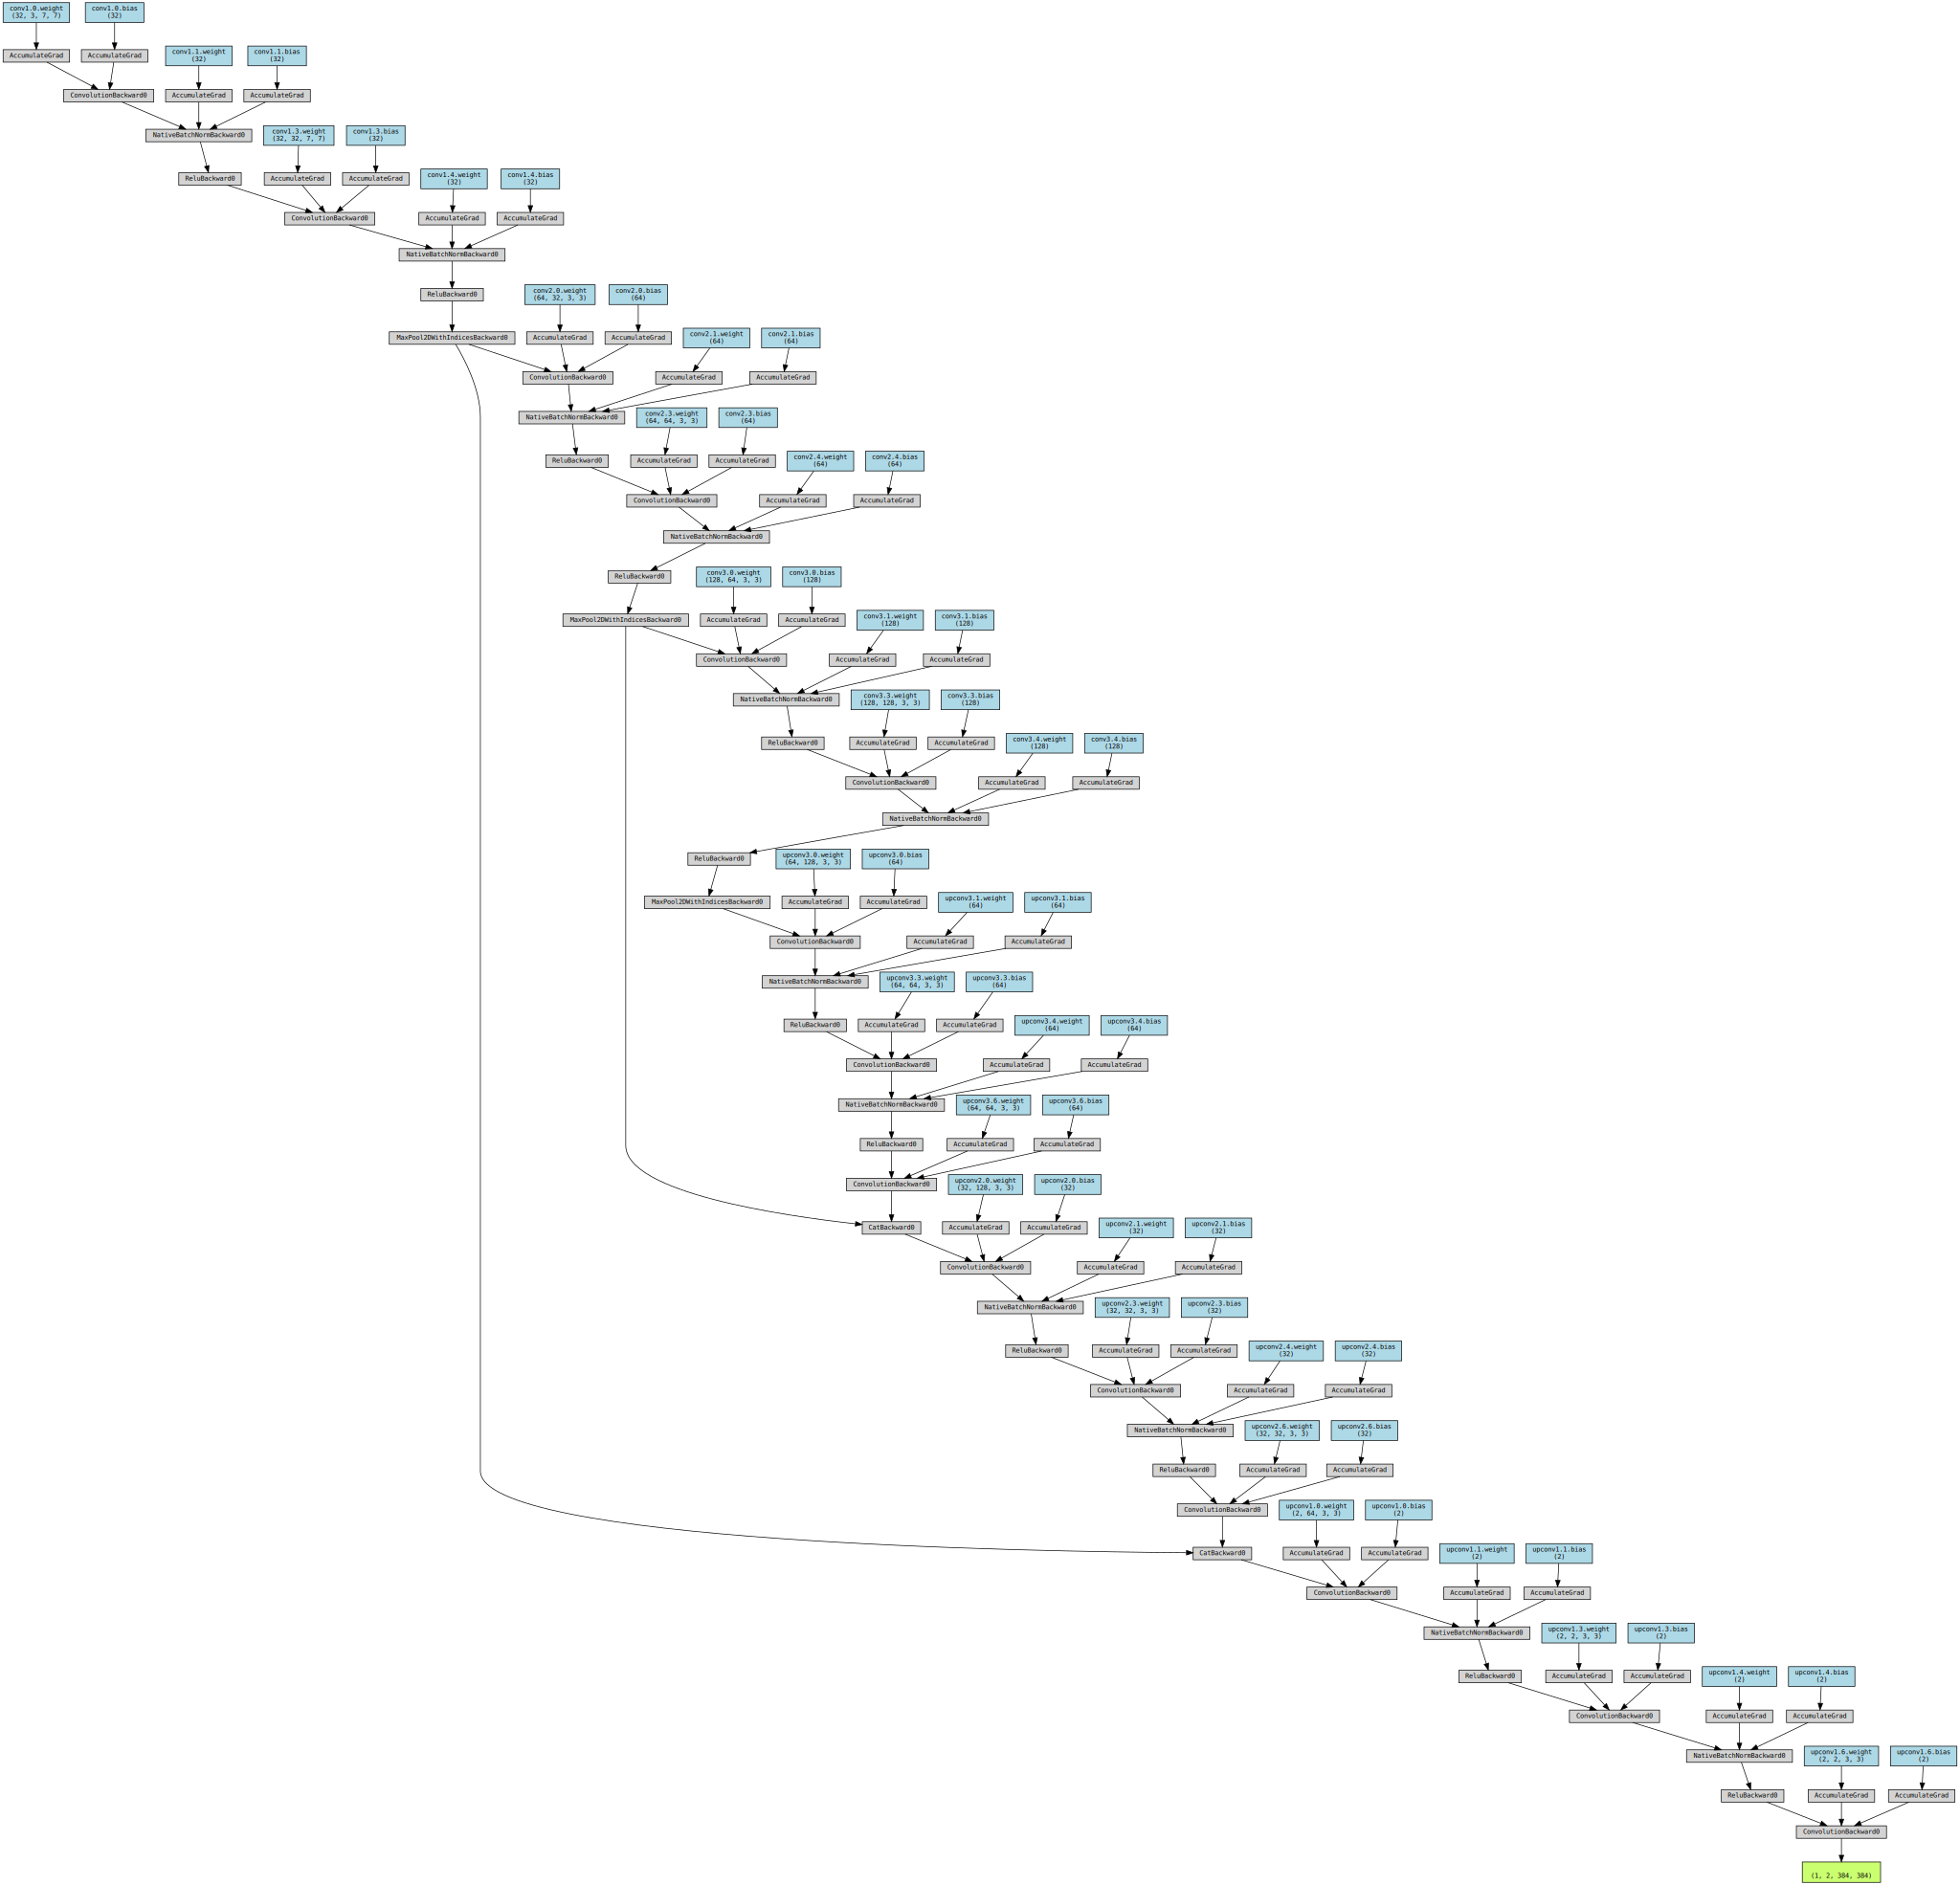

In [ ]:
# from torchviz import make_dot

# model = UNET(3, 2)
# model.eval()
# # summary model
# make_dot(model(xb.unsqueeze(0)), params=dict(model.named_parameters()), max_attr_chars=10)


In [ ]:
if torch.cuda.is_available():
  print('CUDA is available!')
  device = torch.device('cuda')
else:
  print('CUDA is not available.')
  device = torch.device('cpu')

device

CUDA is available!


device(type='cuda')

In [ ]:
import torch
from IPython.display import clear_output

def train_with_early_stop(model,
                          train_dl,
                          valid_dl,
                          loss_fn,
                          optimizer,
                          acc_fn,
                          threshold=0.5,
                          epochs=100,
                          patience=10,
                          checkpoint_path='checkpoint.pth'):
    if torch.cuda.is_available():
      model.cuda()
    # model.cuda()

    best_acc = 0.0
    early_stop_counter = 0  # Counter to track early stopping

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set training mode = True
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluation mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            running_dice = 0.0
            running_accuracy = 0.0

            step = 0

            # Iterate over data
            for x, y in dataloader:
                if(torch.cuda.is_available()):
                  x = x.cuda()
                  y = y.cuda()

                step += 1

                # Forward pass
                if phase == 'train':
                    # Zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # Backward pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # Calculate accuracy
                acc = acc_fn(outputs, y, threshold=threshold)

                # calculate dice coef
                acc_dice = dice_coefficient(outputs, y, threshold=threshold)

                #calculate accuracy
                accuracy_value = accuracy(outputs, y, threshold=threshold)

                running_acc += acc * dataloader.batch_size
                running_dice += acc_dice * dataloader.batch_size
                running_accuracy += accuracy_value * dataloader.batch_size
                running_loss += loss * dataloader.batch_size

                if step % 100 == 0 and torch.cuda.is_available():

                    print('Current step: {}  Loss: {:.4f}  Acc: {:.4f}  AllocMem (Mb): {:.2f}'.format(step, loss, acc, torch.cuda.memory_allocated() / 1024 / 1024))


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            epoch_dice = running_dice / len(dataloader.dataset)
            epoch_accuracy = running_accuracy / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            wandb.log({f'{phase}_epoch/IoU': epoch_acc,
                       f"{phase}_epoch/Dice":epoch_dice,
                       f"{phase}_epoch/accuracy": epoch_accuracy})
            wandb.log({f"{phase}_epoch/loss":epoch_loss})
            print('-' * 10)

            # Check for early stopping
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                early_stop_counter = 0
                # Save the model checkpoint when validation accuracy improves
                torch.save(model.state_dict(), f'best_{checkpoint_path}')
                torch.save( {'opt':optimizer.state_dict()}, f'best_hyper_params_{config["PATH_OUT_MODEL"]}.pth')
            elif phase == 'valid':
                early_stop_counter += 1

        # Early stopping condition
        if early_stop_counter >= patience:
            print('Early stopping after {} epochs without improvement.'.format(patience))
            break

In [ ]:
loss_fn = nn.CrossEntropyLoss()
unet = UNET(config['IN_CHANEL'], config['OUT_CHANNEL'])
opt = torch.optim.Adam(unet.parameters(), lr=config['LR'])


train_with_early_stop(unet,
                      train_dataload,
                      valid_dataload,
                      loss_fn,opt,acc_fn=iou_metric,
                      threshold=config['THRESHOLD'],
                      epochs=config['EPOCHS'],
                      patience=config['PATIENT'],
                      checkpoint_path=config['PATH_OUT_MODEL'])

Epoch 124/499
----------
valid Loss: 0.2214 Acc: 0.8584
----------
Early stopping after 35 epochs without improvement.


In [ ]:
train_loss = torch.tensor(train_loss)
valid_loss = torch.tensor(valid_loss)

In [ ]:
train_loss = np.array(train_loss.cpu())
valid_loss = np.array(valid_loss.cpu())

plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save last epochs
torch.save( unet.state_dict(), f'last_{config["PATH_OUT_MODEL"]}' )



In [ ]:
# save opt and train loss and valid loss, and epoch
torch.save( unet.state_dict(), f'last_{config["PATH_OUT_MODEL"]}' )
torch.save( {'opt':opt.state_dict(), 'train_loss':train_loss, 'valid_loss':valid_loss, 'epoch':37}, f'last_hyper_params_{config["PATH_OUT_MODEL"]}.pth' )

## FPN-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision.models import resnet18
from torch.nn.functional import interpolate
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SemiBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1, norm_layer=nn.BatchNorm2d):
        super(SemiBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out



class UpsampleModule(nn.Module):
    def __init__(self, in_chs, decoder_chs, norm_layer):
        super(UpsampleModule, self).__init__()

        self.down_conv = nn.Conv2d(in_chs, decoder_chs, kernel_size=1, bias=False)
        self.down_bn = norm_layer(decoder_chs)
        downsample = nn.Sequential(
            self.down_conv,
            self.down_bn,
        )
        self.conv_enc = SemiBasicBlock(in_chs, decoder_chs, downsample=downsample, norm_layer=norm_layer)
        self.conv_out = SemiBasicBlock(decoder_chs, decoder_chs, norm_layer=norm_layer)
        self.conv_up = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)

    def forward(self, enc, prev):
        enc = self.conv_up(prev) + self.conv_enc(enc)
        dec = self.conv_out(enc)
        return dec


class FPNHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(FPNHead, self).__init__()
        decoder_chs = out_channels
        layer_chs_list = [512, 256, 128, 64]  # Update the layer channels based on your input size

        self.conv_enc2dec = nn.Conv2d(layer_chs_list[0], decoder_chs, kernel_size=1, bias=False)
        self.bn_enc2dec = norm_layer(out_channels)
        self.relu_enc2dec = nn.ReLU(inplace=True)

        self.up3 = UpsampleModule(layer_chs_list[1], decoder_chs, norm_layer)
        self.up2 = UpsampleModule(layer_chs_list[2], decoder_chs, norm_layer)
        self.up1 = UpsampleModule(layer_chs_list[3], decoder_chs, norm_layer)

        self.conv_up0 = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)
        self.conv_up1 = nn.ConvTranspose2d(decoder_chs, out_channels, kernel_size=2, stride=2, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, c1, c2, c3, c4):
        c4 = self.relu_enc2dec(self.bn_enc2dec(self.conv_enc2dec(c4)))
        c3 = self.up3(c3, c4)
        c2 = self.up2(c2, c3)
        c1 = self.up1(c1, c2)

        c1 = self.conv_up0(c1)
        c1 = self.conv_up1(c1)
        return c1



class FPN(nn.Module):
    def __init__(self, backbone, num_classes, pretrained=False, norm_layer=nn.BatchNorm2d):
        super(FPN, self).__init__()
        self.backbone = backbone
        self.num_classes = num_classes

        if backbone == 'resnet18':
            self.pretrained = resnet18(pretrained=pretrained)
            self.base_forward = self._resnet_base_forward

        in_chs_dict = {"resnet18": 512}  # Update the input channels based on your backbone
        in_chs = in_chs_dict[backbone]
        self.head = FPNHead(in_chs, num_classes, norm_layer)

        self._initialize_weights()

    def _resnet_base_forward(self, x):
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)
        return c1, c2, c3, c4

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        _, _, h, w = x.size()
        c1, c2, c3, c4 = self.base_forward(x)
        x = self.head(c1, c2, c3, c4)
        x = torch.sigmoid(x)  # Apply sigmoid activation for binary classification
        x = interpolate(x, size=(h, w), mode='bilinear', align_corners=False)  # Resize output to input size
        return x





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


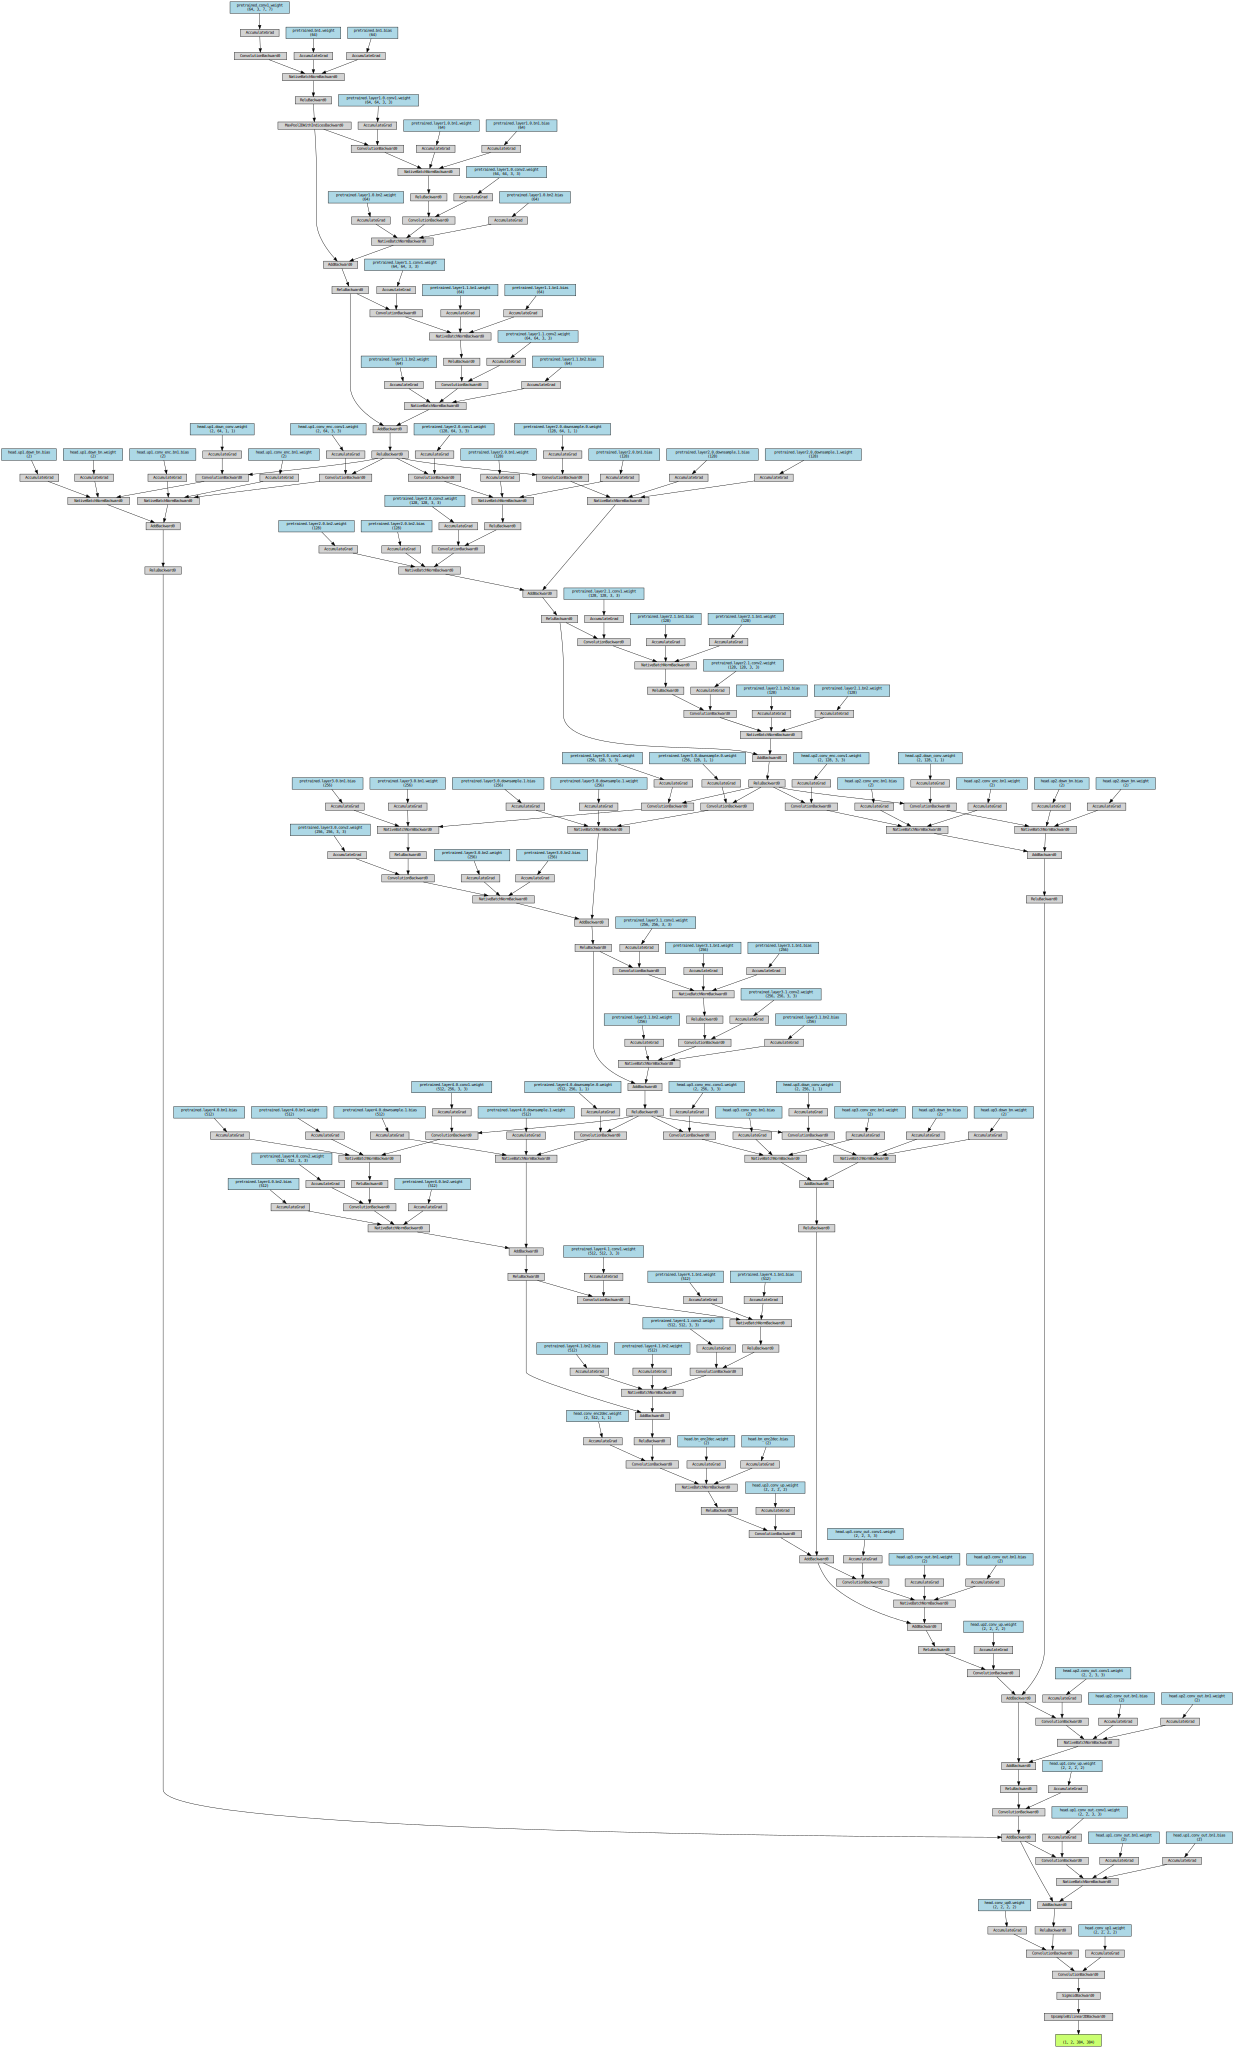

In [ ]:
from torchviz import make_dot

model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
model.eval()
# summary model
make_dot(model(xb.unsqueeze(0)), params=dict(model.named_parameters()), max_attr_chars=10)


In [ ]:
import time
import torch
from IPython.display import clear_output

def train_with_early_stop(model,
                          train_dl,
                          valid_dl,
                          loss_fn,
                          optimizer,
                          acc_fn,
                          threshold=0.5,
                          epochs=100,
                          patience=10,
                          checkpoint_path='checkpoint.pth'):
    start = time.time()
    if torch.cuda.is_available():
      model.cuda()
    # model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    early_stop_counter = 0  # Counter to track early stopping

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set training mode = True
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluation mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            running_dice = 0.0
            running_accuracy = 0.0

            step = 0

            # Iterate over data
            for x, y in dataloader:
                if(torch.cuda.is_available()):
                  x = x.cuda()
                  y = y.cuda()

                step += 1

                # Forward pass
                if phase == 'train':
                    # Zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # Backward pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # Calculate accuracy
                acc = acc_fn(outputs, y, threshold=threshold)

                # calculate dice coef
                acc_dice = dice_coefficient(outputs, y, threshold=threshold)

                #calculate accuracy
                accuracy_value = accuracy(outputs, y, threshold=threshold)

                running_acc += acc * dataloader.batch_size
                running_dice += acc_dice * dataloader.batch_size
                running_accuracy += accuracy_value * dataloader.batch_size
                running_loss += loss * dataloader.batch_size

                if step % 100 == 0 and torch.cuda.is_available():

                    print('Current step: {}  Loss: {:.4f}  Acc: {:.4f}  AllocMem (Mb): {:.2f}'.format(step, loss, acc, torch.cuda.memory_allocated() / 1024 / 1024))


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            epoch_dice = running_dice / len(dataloader.dataset)
            epoch_accuracy = running_accuracy / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            wandb.log({f'{phase}_epoch/IoU': epoch_acc,
                       f"{phase}_epoch/Dice":epoch_dice,
                       f"{phase}_epoch/accuracy": epoch_accuracy})
            wandb.log({f"{phase}_epoch/loss":epoch_loss})
            print('-' * 10)

            train_loss.append(epoch_loss) if phase == 'train' else valid_loss.append(epoch_loss)

            # Check for early stopping
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                early_stop_counter = 0
                # Save the model checkpoint when validation accuracy improves
                torch.save(model.state_dict(), f'best_{checkpoint_path}')
                torch.save( {'opt':optimizer.state_dict(), 'train_loss':train_loss, 'valid_loss':valid_loss, 'epoch':37}, f'best_hyper_params_{config["PATH_OUT_MODEL"]}.pth')
            elif phase == 'valid':
                early_stop_counter += 1

        # Early stopping condition
        if early_stop_counter >= patience:
            print('Early stopping after {} epochs without improvement.'.format(patience))
            break

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss


In [ ]:
loss_fn = nn.CrossEntropyLoss()
fpn_model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
opt = torch.optim.Adam(fpn_model.parameters(), lr=config['LR'])

train_loss, valid_loss = train_with_early_stop(fpn_model,
                                               train_dataload,
                                               valid_dataload,
                                               loss_fn,
                                               opt,
                                               acc_fn=iou_metric,
                                               threshold=config['THRESHOLD'],
                                               epochs=config['EPOCHS'],
                                               patience=config['PATIENT'],
                                               checkpoint_path=config['PATH_OUT_MODEL']
                                               )

Epoch 158/499
----------
train Loss: 0.3708 Acc: 0.8860
----------


KeyboardInterrupt: 

In [ ]:
# save opt and train loss and valid loss, and epoch
torch.save( fpn_model.state_dict(), f'last_{config["PATH_OUT_MODEL"]}' )
torch.save( {'opt':opt.state_dict(), 'epoch':158}, f'last_hyper_params_{config["PATH_OUT_MODEL"]}.pth' )

## lighning

In [ ]:
!pip install lightning

In [ ]:
def iou_metric(predb, yb, threshold=0.5):

    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / union

    return iou


def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff


def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy


In [ ]:
from torch import nn

class SemiBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1, norm_layer=nn.BatchNorm2d):
        super(SemiBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [ ]:
from torch import nn

class UpsampleModule(nn.Module):
    def __init__(self, in_chs, decoder_chs, norm_layer):
        super(UpsampleModule, self).__init__()

        self.down_conv = nn.Conv2d(in_chs, decoder_chs, kernel_size=1, bias=False)
        self.down_bn = norm_layer(decoder_chs)
        downsample = nn.Sequential(
            self.down_conv,
            self.down_bn,
        )
        self.conv_enc = SemiBasicBlock(in_chs, decoder_chs, downsample=downsample, norm_layer=norm_layer)
        self.conv_out = SemiBasicBlock(decoder_chs, decoder_chs, norm_layer=norm_layer)
        self.conv_up = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)

    def forward(self, enc, prev):
        enc = self.conv_up(prev) + self.conv_enc(enc)
        dec = self.conv_out(enc)
        return dec

In [ ]:
from torch import nn

class FPNHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(FPNHead, self).__init__()
        decoder_chs = out_channels
        layer_chs_list = [512, 256, 128, 64]  # Update the layer channels based on your input size

        self.conv_enc2dec = nn.Conv2d(layer_chs_list[0], decoder_chs, kernel_size=1, bias=False)
        self.bn_enc2dec = norm_layer(out_channels)
        self.relu_enc2dec = nn.ReLU(inplace=True)

        self.up3 = UpsampleModule(layer_chs_list[1], decoder_chs, norm_layer)
        self.up2 = UpsampleModule(layer_chs_list[2], decoder_chs, norm_layer)
        self.up1 = UpsampleModule(layer_chs_list[3], decoder_chs, norm_layer)

        self.conv_up0 = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)
        self.conv_up1 = nn.ConvTranspose2d(decoder_chs, out_channels, kernel_size=2, stride=2, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, c1, c2, c3, c4):
        c4 = self.relu_enc2dec(self.bn_enc2dec(self.conv_enc2dec(c4)))
        c3 = self.up3(c3, c4)
        c2 = self.up2(c2, c3)
        c1 = self.up1(c1, c2)

        c1 = self.conv_up0(c1)
        c1 = self.conv_up1(c1)
        return c1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision.models import resnet18
from torch.nn.functional import interpolate
import lightning as L
from torch.optim.lr_scheduler import ReduceLROnPlateau


class FPN(L.LightningModule):
    def __init__(self, backbone, num_classes, pretrained=False, norm_layer=nn.BatchNorm2d):
        super(FPN, self).__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.config = config

        if backbone == 'resnet18':
            self.pretrained = resnet18(pretrained=pretrained)
            self.base_forward = self._resnet_base_forward

        in_chs_dict = {"resnet18": 512}  # Update the input channels based on your backbone
        in_chs = in_chs_dict[backbone]
        self.head = FPNHead(in_chs, num_classes, norm_layer)

        self._initialize_weights()

    def _resnet_base_forward(self, x):
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)
        return c1, c2, c3, c4

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        _, _, h, w = x.size()
        c1, c2, c3, c4 = self.base_forward(x)
        x = self.head(c1, c2, c3, c4)
       # x = torch.sigmoid(x)  # Apply sigmoid activation for binary classification
        x = interpolate(x, size=(h, w), mode='bilinear', align_corners=False)  # Resize output to input size
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y.long())
        iou = iou_metric(y_hat, y)
        dice_coefficient_value = dice_coefficient(y_hat, y)
        accuracy_value = accuracy(y_hat, y)

        self.log('train_epoch/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_epoch/IoU', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_epoch/Dice', dice_coefficient_value, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', accuracy_value, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y.long())
        iou = iou_metric(y_hat, y)
        dice_coefficient_value = dice_coefficient(y_hat, y)
        accuracy_value = accuracy(y_hat, y)

        self.log('valid_epoch/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_epoch/IoU', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_epoch/Dice', dice_coefficient_value, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', accuracy_value, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        # return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}
        return optimizer



In [ ]:
transform = A.Compose([
            A.HorizontalFlip(p=p_transform),
            A.VerticalFlip(p=p_transform),
            A.RandomRotate90(p=p_transform),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=p_transform),
            A.RandomBrightnessContrast(p=p_transform),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True, transform=None):
        super().__init__()

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(
            f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.transform = transform

    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):

        files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

    def __len__(self):

        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                            ], axis=2)

        if include_nir:
            nir = np.expand_dims(
                np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))

        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def open_mask(self, idx, add_dims=False):

        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):

        x = torch.tensor(self.open_as_array(
            idx, invert=self.pytorch, include_nir=False), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False),
                         dtype=torch.torch.int64)

        if self.transform:
            x = x.permute(1,2,0)
            augmented = self.transform(image=x.numpy(), mask=y.numpy())
            x = augmented['image']
            y = augmented['mask']
        return x, y

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random


class CloudDataModule(L.LightningDataModule):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, transforms, batch_size: int = 32, num_workers: int = 4, seed: int = 42):
        super().__init__()
        self.r_dir = r_dir
        self.g_dir = g_dir
        self.b_dir = b_dir
        self.nir_dir = nir_dir
        self.gt_dir = gt_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.transforms = transforms

    def prepare_data(self):
        # download, split, etc...
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        # This is called on every process in DDP
        dataset = CloudDataset(
            self.r_dir, self.g_dir, self.b_dir, self.nir_dir, self.gt_dir, transform=self.transforms)
        remove_images_with_high_black_percentage(dataset)

        # Split your dataset into train and validation sets
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(
            dataset, [train_size, val_size], generator=torch.Generator().manual_seed(self.seed))
        print(len(train_dataset), len(val_dataset))

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, persistent_workers=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, persistent_workers=True, num_workers=self.num_workers)

In [ ]:
import lightning as L
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from lightning.pytorch.callbacks import EarlyStopping


earlystop_callback = EarlyStopping(
        monitor='valid_epoch/loss',
        min_delta=0.00,
        patience=config['PATIENT'],
        verbose=True,
        mode='min'
    )

data = CloudDataModule(base_path/'train_red',
                        base_path/'train_green',
                        base_path/'train_blue',
                        base_path/'train_nir',
                        base_path/'train_gt',
                        batch_size=config['BATCH_SIZE'],
                        num_workers=6,
                        seed = 17,
                        transforms=transform
                        )


logger = WandbLogger(name=config['PATH_OUT_MODEL'], project="38-Cloud", log_model='all', save_dir=config['PATH_OUT_MODEL'])
logger.log_hyperparams(config)

model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
trainer = L.Trainer(logger=logger, accelerator="gpu", devices=1, max_epochs=config['EPOCHS'], callbacks=[earlystop_callback])

trainer.fit(model, data)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available

4124 1031


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_epoch/loss improved. New best score: 0.683
INFO:lightning.pytorch.callbacks.early_stopping:Metric valid_epoch/loss improved. New best score: 0.683


EOFError: 

## mockup

In [ ]:
import pandas as pd

results = []

results.append({
    'Model Path': "u-net",
    'Loss': 0.5195,
    'IoU (Accuracy)': 0.6504,
    'Dice': 0.7844,
    'Precision': 0.8200,
    'Recall': 0.7583,
    'F1-score': 0.7844
})

results.append({
    'Model Path': "fpn-net",
    'Loss': 0.4645,
    'IoU (Accuracy)': 0.6875,
    'Dice': 0.8117,
    'Precision': 0.8410,
    'Recall': 0.7899,
    'F1-score': 0.8117
})

results.append({
    'Model Path': "yolo",
    'Loss': 0,
    'IoU (Accuracy)': 0.6091,
    'Dice': 0.7105,
    'Precision': 0.9169,
    'Recall': 0.6731,
    'F1-score': 0.7105,
    'overall accuracy': 0.7577
})

results.append({
    'Model Path': "Cloud-net",
    'Loss': 0.5195,
    'IoU (Accuracy)': 78.50,
    'Dice': 0,
    'Precision': 82.0,
    'Recall': 75.83,
    'F1-score': 0
})


df = pd.DataFrame(results)
df.to_csv("run_tests.csv")


## Eval Models

In [ ]:
# import torch

# def eval_model(model, dataloader, loss_fn, acc_fn, dice_coefficient, threshold=0.5):
#     if torch.cuda.is_available():
#         model.cuda()
#     model.eval()  # Set model to evaluation mode

#     running_loss = 0.0
#     running_acc = 0.0
#     running_dice = 0.0
#     running_accuracy = 0.0

#     with torch.no_grad():  # Important to not compute gradients during evaluation
#         for x, y in dataloader:
#             if torch.cuda.is_available():
#                 x = x.cuda()
#                 y = y.cuda()

#             outputs = model(x)
#             loss = loss_fn(outputs, y.long())

#             acc = acc_fn(outputs, y, threshold=threshold)
#             dice = dice_coefficient(outputs, y, threshold=threshold)
#             # Assuming accuracy function is similar to acc_fn but specifically for accuracy metric
#             accuracy_value = accuracy(outputs, y, threshold=threshold)  # Modify this if your accuracy calculation is different

#             running_loss += loss.item() * x.size(0)
#             running_acc += acc.item() * x.size(0)
#             running_dice += dice.item() * x.size(0)
#             running_accuracy += accuracy_value.item() * x.size(0)

#     # Calculate the average over all batches
#     final_loss = running_loss / len(dataloader.dataset)
#     final_acc = running_acc / len(dataloader.dataset)
#     final_dice = running_dice / len(dataloader.dataset)
#     final_accuracy = running_accuracy / len(dataloader.dataset)

#     return final_loss, final_acc, final_dice, final_accuracy



In [ ]:
import torch

def eval_model(model, dataloader, loss_fn, acc_fn, dice_coefficient, precision_fn, recall_fn, f1_score_fn, threshold=0.5):
    if torch.cuda.is_available():
        model.cuda()
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    running_acc = 0.0
    running_dice = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1_score = 0.0

    with torch.no_grad():  # Important to not compute gradients during evaluation
        for x, y in dataloader:
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y.long())

            acc = acc_fn(outputs, y, threshold=threshold)
            dice = dice_coefficient(outputs, y, threshold=threshold)
            precision = precision_fn(outputs, y, threshold=threshold)
            recall = recall_fn(outputs, y, threshold=threshold)
            f1_score = f1_score_fn(outputs, y, threshold=threshold)

            # Assuming accuracy function is similar to acc_fn but specifically for accuracy metric
            accuracy_value = accuracy(outputs, y, threshold=threshold)  # Modify this if your accuracy calculation is different

            running_loss += loss.item() * x.size(0)
            running_acc += acc.item() * x.size(0)
            running_dice += dice.item() * x.size(0)
            running_accuracy += accuracy_value.item() * x.size(0)
            running_precision += precision.item() * x.size(0)
            running_recall += recall.item() * x.size(0)
            running_f1_score += f1_score.item() * x.size(0)

    # Calculate the average over all batches
    final_loss = running_loss / len(dataloader.dataset)
    final_acc = running_acc / len(dataloader.dataset)
    final_dice = running_dice / len(dataloader.dataset)
    final_accuracy = running_accuracy / len(dataloader.dataset)
    final_precision = running_precision / len(dataloader.dataset)
    final_recall = running_recall / len(dataloader.dataset)
    final_f1_score = running_f1_score / len(dataloader.dataset)

    return final_loss, final_acc, final_dice, final_accuracy, final_precision, final_recall, final_f1_score


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = UNET(in_channels=3, out_channels=2)
print("Número total de parâmetros da UNET:", count_parameters(model))
model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
print("Número total de parâmetros da FPN:", count_parameters(model))

Número total de parâmetros da UNET: 537366


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Número total de parâmetros da FPN: 11699724


In [ ]:
results = []

In [ ]:
model = UNET(in_channels=3, out_channels=2)

if torch.cuda.is_available():
    model.load_state_dict(torch.load("/content/drive/MyDrive/TCC/unet/best_Unet-NET_b32_e500_p35_lr0.001_i3_o2_epoch124EarlyStop.pth"))

loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc, test_dice, test_accuracy, test_precision, test_recall, test_f1_score = eval_model(model, valid_dataload, loss_fn, acc_fn=iou_metric, dice_coefficient=dice_coefficient, precision_fn=precision, recall_fn=recall, f1_score_fn=f1_score)

results.append({
        'Model Path': "u-net",
        'Loss': test_loss,
        'IoU (Accuracy)': test_acc,
        'Dice': test_dice,
        'Overall Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1_score
    })
print(f"Test Loss: {test_loss:.4f}, Test Accuracy(IoU): {test_acc:.4f}, Teste overall Acuracy: {test_accuracy}, Test Dice: {test_dice:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1_score:.4f}")


Test Loss: 0.3450, Test Accuracy(IoU): 0.6563, Teste overall Acuracy: 0.8900589634710392, Test Dice: 0.7864, Test Precision: 0.8300, Test Recall: 0.7564, Test F1 Score: 0.7864


In [ ]:
model = FPN(backbone='resnet18', num_classes=2, pretrained=False)

if torch.cuda.is_available():
    model.load_state_dict(torch.load("/content/drive/MyDrive/TCC/fpn-net/best_FPN-NET_b32_e500_p35_lr0.001_i3_o2_epoch150.pth"))

loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc, test_dice, test_accuracy, test_precision, test_recall, test_f1_score = eval_model(model, valid_dataload, loss_fn, acc_fn=iou_metric, dice_coefficient=dice_coefficient, precision_fn=precision, recall_fn=recall, f1_score_fn=f1_score)

results.append({
        'Model Path': "Fpn-net",
        'Loss': test_loss,
        'IoU (Accuracy)': test_acc,
        'Dice': test_dice,
        'Overall Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1_score
    })
print(f"Test Loss: {test_loss:.4f}, Test Accuracy(IoU): {test_acc:.4f}, Teste overall Acuracy: {test_accuracy}, Test Dice: {test_dice:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1_score:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 0.4058, Test Accuracy(IoU): 0.6948, Teste overall Acuracy: 0.9047938726549668, Test Dice: 0.8139, Test Precision: 0.8505, Test Recall: 0.7900, Test F1 Score: 0.8139


In [ ]:
results

[{'Model Path': 'u-net',
  'Loss': 0.519458737497812,
  'IoU (Accuracy)': 0.649591442811353,
  'Dice': 0.78333451979312,
  'Overall Accuracy': 0.8247044617355745,
  'Precision': 0.8200126417698324,
  'Recall': 0.7577358484268188,
  'F1 Score': 0.7833344601884752},
 {'Model Path': 'Fpn-net',
  'Loss': 0.4644500366723557,
  'IoU (Accuracy)': 0.685423910812297,
  'Dice': 0.8090757672199417,
  'Overall Accuracy': 0.8447674527448309,
  'Precision': 0.8382728110518775,
  'Recall': 0.7877890191498238,
  'F1 Score': 0.8090757068374224}]

In [ ]:
results.append({
        'Model Path': "Yolo",
        'Loss': 0,
        'IoU (Accuracy)': 0.6091,
        'Dice': 0.7105,
        'Overall Accuracy': 0.7577,
        'Precision': 0.9169,
        'Recall': 0.6731,
        'F1 Score': 0.7105
    })

results.append({
        'Model Path': "Cloud-net",
        'Loss': 0,
        'IoU (Accuracy)': 78.50,
        'Dice': 0,
        'Overall Accuracy': 96.48,
        'Precision': 82.0,
        'Recall': 75.83,
        'F1 Score': 0
    })




In [ ]:
import pandas as pd
df = pd.DataFrame(results)
df

,Model Path,Loss,IoU (Accuracy),Dice,Overall Accuracy,Precision,Recall,F1 Score
0,u-net,0.519459,0.649591,0.783335,0.824704,0.820013,0.757736,0.783334
1,Fpn-net,0.464450,0.685424,0.809076,0.844767,0.838273,0.787789,0.809076
2,Yolo,0.000000,0.609100,0.710500,0.757700,0.916900,0.673100,0.710500
3,Cloud-net,0.000000,78.500000,0.000000,96.480000,82.000000,75.830000,0.000000


In [ ]:
# model = UNET(in_channels=3, out_channels=2)

# if torch.cuda.is_available():
#     model.load_state_dict(torch.load("/content/best_Unet-NET_b32_e500_p35_lr0.001_i3_o2_epoch124EarlyStop.pth"))

# loss_fn = nn.CrossEntropyLoss()

# test_loss, test_acc, test_dice, test_accuracy = eval_model(model, valid_dataload, loss_fn, acc_fn=iou_metric, dice_coefficient=dice_coefficient)

# results.append({
#         'Model Path': "u-net",
#         'Test Loss': test_loss,
#         'Test IoU (Accuracy)': test_acc,
#         'Test Dice': test_dice,
#         'Test Acc': test_accuracy
#     })
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Dice: {test_dice:.4f}, Test IoU (Accuracy): {test_accuracy:.4f}")

NameError: name 'UNET' is not defined

In [ ]:
# model = FPN(backbone='resnet18', num_classes=2, pretrained=False)

# if torch.cuda.is_available():
#     model.load_state_dict(torch.load("/content/best_FPN-NET_b32_e500_p35_lr0.001_i3_o2_epoch150.pth"))

# loss_fn = nn.CrossEntropyLoss()

# test_loss, test_acc, test_dice, test_accuracy = eval_model(model, valid_dataload, loss_fn, acc_fn=iou_metric, dice_coefficient=dice_coefficient)
# results.append({
#         'Model Path': "fpn-net",
#         'Test Loss': test_loss,
#         'Test IoU (Accuracy)': test_acc,
#         'Test Dice': test_dice,
#         'Test Acc': test_accuracy
#     })
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Dice: {test_dice:.4f}, Test IoU (Accuracy): {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 0.4751, Test Accuracy: 0.6736, Test Dice: 0.8014, Test IoU (Accuracy): 0.6736


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
import numpy as np
import cv2

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def precision_recall_f1(pred_mask, gt_mask, threshold=0.5):
    true_positives = np.sum(np.logical_and(pred_mask > threshold, gt_mask == 1))
    false_positives = np.sum(np.logical_and(pred_mask > threshold, gt_mask == 0))
    false_negatives = np.sum(np.logical_and(pred_mask <= threshold, gt_mask == 1))

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, f1_score

def overall_accuracy(pred_mask, gt_mask):
    total_pixels = np.prod(pred_mask.shape)
    correct_pixels = np.sum(pred_mask == gt_mask)
    overall_acc = correct_pixels / total_pixels
    return overall_acc

overall_accuracy_scores = []


dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

yolo_model = YOLO("/content/drive/MyDrive/TCC/yolo/best_f.pt")
image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        original_image = cv2.imread(image_file)

        mask_image = np.zeros_like(original_image)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    points = np.int32([mask])
                    cv2.fillPoly(mask_image, [points], (255, 255, 255))

        if np.any(mask_image):
            pred_mask = mask_image[..., 0] > 0

            gt_mask_file = os.path.join(mask_path, filename)
            gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
            gt_mask = (gt_mask_img > 0).astype(np.uint8)

            iou = calculate_iou(pred_mask, gt_mask)
            overall_acc = overall_accuracy(pred_mask, gt_mask)

            iou_scores.append(iou)
            overall_accuracy_scores.append(overall_acc)

            precision, recall, f1_score = precision_recall_f1(pred_mask, gt_mask, threshold=0.6)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1_score)

        processed_images += 1
        if processed_images >= 100:
            break

mean_iou = np.mean(iou_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1_score = np.mean(f1_scores)
mean_overall_accuracy = np.mean(overall_accuracy_scores)

print("Mean IoU:", mean_iou)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("overall acuracy: ", mean_overall_accuracy)


Mean IoU: 0.6072156882065279
Mean Precision: 0.8826650446920125
Mean Recall: 0.6934830789255989
Mean F1 Score: 0.7101757609893391
overall acuracy:  0.8299948071676588


In [ ]:
results.append({
        'Model Path': "yolo",
        'Test Loss': 0,
        'Test IoU (Accuracy)': mean_iou,
        'Test Dice': mean_dice,
        'Test Accuracy': 0,
        'Test Precision': mean_precision,
        'Test Recall': mean_recall,
        'Test F1 Score': mean_f1_score
    })

In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

path = "image_1313.png"
image_path = "/content/yolo/images/val/"

results = yolo_model(os.path.join(image_path, path))  # Substitua pela sua chamada correta de predição do modelo

# Carregar a imagem original
original_image = cv2.imread(os.path.join(image_path, path))

# Criar uma imagem em branco com as mesmas dimensões da original
mask_image = np.zeros_like(original_image)

for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])
        color_number = classes_ids.index(int(box.cls[0]))
        cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca


pred_mask = mask_image[..., 0] > 0  # Transformar a máscara em um array booleano

mask_path = os.path.join(image_path, "mask", path)
gt_mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = (gt_mask_img > 0).astype(np.uint8)


calculate_iou(pred_mask, gt_mask)



image 1/1 /content/yolo/images/val/image_1313.png: 384x384 10 clouds, 32.1ms
Speed: 1.0ms preprocess, 32.1ms inference, 17.8ms postprocess per image at shape (1, 3, 384, 384)
Shape of pred_mask: (384, 384)
Shape of gt_mask: (384, 384)


0.16184812191300044

In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

iou_scores = []
processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        # Carregar a imagem original
        original_image = cv2.imread(image_file)

        # Criar uma imagem em branco com as mesmas dimensões da original
        mask_image = np.zeros_like(original_image)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    points = np.int32([mask])
                    cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca

        if np.any(mask_image):  # Verificar se a máscara não está vazia
            pred_mask = mask_image[..., 0] > 0  # Transformar a máscara em um array booleano

            gt_mask_file = os.path.join(mask_path, filename)
            gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
            gt_mask = (gt_mask_img > 0).astype(np.uint8)

            iou = calculate_iou(pred_mask, gt_mask)
            iou_scores.append(iou)

        # Liberar recursos de memória
        original_image = None
        mask_image = None
        pred_mask = None
        gt_mask_img = None
        gt_mask = None

        processed_images += 1
        if processed_images >= 100:  # Limite o número de imagens processadas
            break

mean_iou = np.mean(iou_scores)
print("Mean IoU:", mean_iou)


Mean IoU: 0.5954386217608136


In [ ]:
def iou_metric(predb, yb, threshold=0.5):

    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / union

    return iou


def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff


def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy


In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = torch.tensor(predb > threshold).float()
    true_mask = torch.tensor(yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

iou_scores = []
dice_scores = []
processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        # Carregar a imagem original
        original_image = cv2.imread(image_file)

        # Criar uma imagem em branco com as mesmas dimensões da original
        mask_image = np.zeros_like(original_image)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    points = np.int32([mask])
                    cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca

        if np.any(mask_image):  # Verificar se a máscara não está vazia
            pred_mask = mask_image[..., 0] > 0  # Transformar a máscara em um array booleano

            gt_mask_file = os.path.join(mask_path, filename)
            gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
            gt_mask = (gt_mask_img > 0).astype(np.uint8)

            iou = calculate_iou(pred_mask, gt_mask)
            dice = dice_coefficient(pred_mask, gt_mask)
            dice_scores.append(dice)
            iou_scores.append(iou)

        # Liberar recursos de memória
        original_image = None
        mask_image = None
        pred_mask = None
        gt_mask_img = None
        gt_mask = None

        processed_images += 1
        if processed_images >= 100:  # Limite o número de imagens processadas
            break

mean_dice = torch.mean(torch.tensor(dice_scores))
mean_iou = np.mean(iou_scores)
print("Mean Dice Coefficient:", mean_dice)
print("Mean IoU:", mean_iou)


Mean Dice Coefficient: tensor(0.7081)
Mean IoU: 0.5954386217608136


In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 0
    return iou

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = torch.tensor(predb > threshold).float()
    true_mask = torch.tensor(yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = torch.tensor(predb > threshold).float()
    true_mask = torch.tensor(yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

iou_scores = []
dice_scores = []
accuracy_scores = []  # Lista para armazenar as acurácias
processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        # Carregar a imagem original
        original_image = cv2.imread(image_file)

        # Criar uma imagem em branco com as mesmas dimensões da original
        mask_image = np.zeros_like(original_image)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    points = np.int32([mask])
                    cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca

        if np.any(mask_image):  # Verificar se a máscara não está vazia
            pred_mask = mask_image[..., 0] > 0  # Transformar a máscara em um array booleano

            gt_mask_file = os.path.join(mask_path, filename)
            gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
            gt_mask = (gt_mask_img > 0).astype(np.uint8)

            iou = calculate_iou(pred_mask, gt_mask)
            dice = dice_coefficient(pred_mask, gt_mask)
            acc = accuracy(pred_mask, gt_mask)  # Calcular a acurácia
            dice_scores.append(dice)
            iou_scores.append(iou)
            accuracy_scores.append(acc)  # Adicionar a acurácia à lista

        # Liberar recursos de memória
        original_image = None
        mask_image = None
        pred_mask = None
        gt_mask_img = None
        gt_mask = None

        processed_images += 1
        if processed_images >= 100:  # Limite o número de imagens processadas
            break

mean_dice = torch.mean(torch.tensor(dice_scores))
mean_iou = np.mean(iou_scores)
mean_accuracy = torch.mean(torch.tensor(accuracy_scores))  # Calcular a média da acurácia
print("Mean Dice Coefficient:", mean_dice)
print("Mean IoU:", mean_iou)
print("Mean Accuracy:", mean_accuracy)  # Imprimir a média da acurácia


Mean Dice Coefficient: tensor(0.7081)
Mean IoU: 0.5954386217608136
Mean Accuracy: tensor(0.7946)


In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

dice_scores = []
accuracy_scores = []
processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    # Carregar a máscara ground truth
                    gt_mask_file = os.path.join(mask_path, filename)
                    gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
                    gt_mask = (gt_mask_img > 0).astype(np.uint8)

                    # Processar a máscara prevista
                    pred_mask = np.zeros_like(gt_mask)
                    points = np.int32([mask])
                    cv2.fillPoly(pred_mask, [points], 255)  # Preencher a máscara com a cor branca
                    pred_mask = (pred_mask > 0).astype(np.uint8)

                    # Converter máscaras para tensores PyTorch
                    pred_mask_tensor = torch.tensor(pred_mask)
                    gt_mask_tensor = torch.tensor(gt_mask)

                    # Calcular métricas
                    dice_score = dice_coefficient(pred_mask_tensor, gt_mask_tensor)
                    accuracy_score = accuracy(pred_mask_tensor, gt_mask_tensor)

                    dice_scores.append(dice_score.item())
                    accuracy_scores.append(accuracy_score.item())

        processed_images += 1
        if processed_images >= 100:  # Limite o número de imagens processadas
            break

mean_dice_coefficient = np.mean(dice_scores)
mean_accuracy = np.mean(accuracy_scores)

print("Mean Dice Coefficient:", mean_dice_coefficient)
print("Mean Accuracy:", mean_accuracy)


Mean Dice Coefficient: 0.7047152196976675
Mean Accuracy: 231.18539061727404


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

yolo_model = YOLO("/content/best_f.pt")

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask))

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels.item() / total_pixels  # Normalizando a precisão
    return accuracy

image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

dice_scores = []
accuracy_scores = []
processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    # Carregar a máscara ground truth
                    gt_mask_file = os.path.join(mask_path, filename)
                    gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
                    gt_mask = (gt_mask_img > 0).astype(np.uint8)

                    # Processar a máscara prevista
                    pred_mask = np.zeros_like(gt_mask)
                    points = np.int32([mask])
                    cv2.fillPoly(pred_mask, [points], 255)  # Preencher a máscara com a cor branca
                    pred_mask = (pred_mask > 0).astype(np.uint8)

                    # Converter máscaras para tensores PyTorch
                    pred_mask_tensor = torch.tensor(pred_mask)
                    gt_mask_tensor = torch.tensor(gt_mask)

                    # Calcular métricas
                    dice_score = dice_coefficient(pred_mask_tensor, gt_mask_tensor)
                    accuracy_score = accuracy(pred_mask_tensor, gt_mask_tensor)

                    dice_scores.append(dice_score.item())
                    accuracy_scores.append(accuracy_score)

        processed_images += 1
        if processed_images >= 100:  # Limite o número de imagens processadas
            break

mean_dice_coefficient = np.mean(dice_scores)
mean_accuracy = np.mean(accuracy_scores)

print("Mean Dice Coefficient:", mean_dice_coefficient)
print("Mean Accuracy:", mean_accuracy)


Mean Dice Coefficient: 0.7047152196976675
Mean Accuracy: 231.1853902953586


In [ ]:
import pandas as pd
df_t = pd.DataFrame(results)
df_t.to_csv("teste_unet_fpn.csv", index=False)

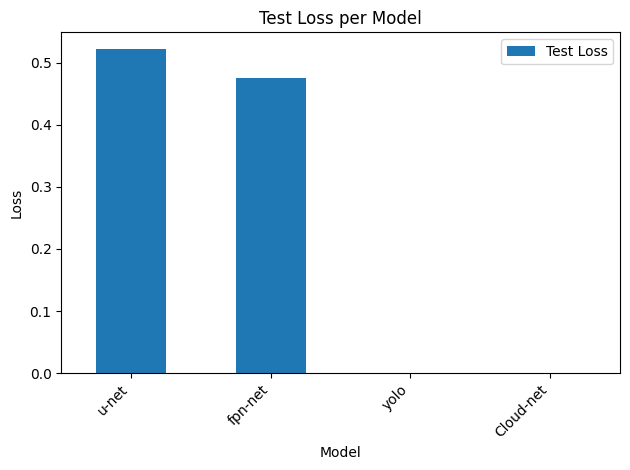

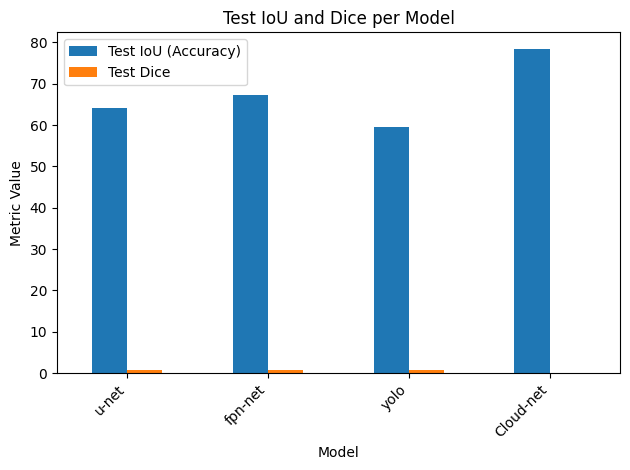

In [ ]:
df.plot(y='Test Loss', kind='bar')
plt.title('Test Loss per Model')
plt.ylabel('Loss')
plt.xlabel('Model')
plt.xticks(range(len(df)), df['Model Path'], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Similarmente, para Test IoU e Test Dice
df.plot(y=['Test IoU (Accuracy)', 'Test Dice'], kind='bar')
plt.title('Test IoU and Dice per Model')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.xticks(range(len(df)), df['Model Path'], rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Cloud-net

### Utils

In [ ]:
import keras
import keras.backend as K
from tqdm import tqdm

class ADAMLearningRateTracker(keras.callbacks.Callback):
    """It prints out the last used learning rate after each epoch (useful for resuming a training)
    original code: https://github.com/keras-team/keras/issues/7874#issuecomment-329347949
    """

    def __init__(self, end_lr):
        super(ADAMLearningRateTracker, self).__init__()
        self.end_lr = end_lr

    def on_epoch_end(self, epoch, logs={}):  # works only when decay in optimizer is zero
        optimizer = self.model.optimizer
        # t = K.cast(optimizer.iterations, K.floatx()) + 1
        # lr_t = K.eval(optimizer.lr * (K.sqrt(1. - K.pow(optimizer.beta_2, t)) /
        #                               (1. - K.pow(optimizer.beta_1, t))))
        # print('\n***The last Actual Learning rate in this epoch is:', lr_t,'***\n')
        print('\n***The last Basic Learning rate in this epoch is:', K.eval(optimizer.lr), '***\n')
        # stops the training if the basic lr is less than or equal to end_learning_rate
        if K.eval(optimizer.lr) <= self.end_lr:
            print("training is finished")
            self.model.stop_training = True


def get_input_image_names(list_names, directory_name, if_train=True):
    list_img = []
    list_msk = []
    list_test_ids = []

    for filenames in tqdm(list_names['name'], miniters=1000):
        nred = 'red_' + filenames
        nblue = 'blue_' + filenames
        ngreen = 'green_' + filenames
        nnir = 'nir_' + filenames

        if if_train:
            dir_type_name = "train"
            fl_img = []
            nmask = 'gt_' + filenames
            fl_msk = directory_name + '/train_gt/' + '{}.TIF'.format(nmask)
            list_msk.append(fl_msk)

        else:
            dir_type_name = "test"
            fl_img = []
            fl_id = '{}.TIF'.format(filenames)
            list_test_ids.append(fl_id)

        fl_img_red = directory_name + '/' + dir_type_name + '_red/' + '{}.TIF'.format(nred)
        fl_img_green = directory_name + '/' + dir_type_name + '_green/' + '{}.TIF'.format(ngreen)
        fl_img_blue = directory_name + '/' + dir_type_name + '_blue/' + '{}.TIF'.format(nblue)
        fl_img_nir = directory_name + '/' + dir_type_name + '_nir/' + '{}.TIF'.format(nnir)
        fl_img.append(fl_img_red)
        fl_img.append(fl_img_green)
        fl_img.append(fl_img_blue)
        fl_img.append(fl_img_nir)

        list_img.append(fl_img)

    if if_train:
        return list_img, list_msk
    else:
        return list_img, list_test_ids


### Model

In [ ]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization,\
    Activation, Dropout
import keras

"""
Some parts borrowed from https://www.kaggle.com/cjansen/u-net-in-keras
"""


def bn_relu(input_tensor):
    """It adds a Batch_normalization layer before a Relu
    """
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def contr_arm(input_tensor, filters, kernel_size):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
       TO DO: remove keras.layers.add and replace it with add only
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def imprv_contr_arm(input_tensor, filters, kernel_size ):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = Conv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = Conv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = Conv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    """It is exactly like the identity_block plus a dropout layer. This block only uses in the valley of the UNet
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = Conv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def conv_block_exp_path3(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    """It is for adding two feed forwards to the output of the two following conv layers in expanding path
    """

    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x


def improve_ff_block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):
    """It improves the skip connection by using previous layers feature maps
       TO DO: shrink all of ff blocks in one function/class
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block2(input_tensor1, input_tensor2, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    x = keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block1(input_tensor1, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=192, input_cols=192, num_of_channels=4, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = imprv_contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block1(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])




### Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from __future__ import print_function
import os
import numpy as np
import tifffile as tiff
import pandas as pd


def mybatch_generator_prediction(images, rows, cols, batch_size, max_bit):
    while True:
        for start in range(0, len(images), batch_size):
            x_batch = []
            end = min(start + batch_size, len(images))
            for img_paths in images[start:end]:
                bands = []
                for img_path in img_paths:
                    img = tiff.imread(img_path)
                    img = img.astype(np.float32) / max_bit  # normalize
                    bands.append(img)
                x_batch.append(np.stack(bands, axis=-1))
            x_batch = np.array(x_batch)
            yield (x_batch,)  # Returning input data as a tuple


def prediction():
    model = model_arch(input_rows=in_rows,
                                       input_cols=in_cols,
                                       num_of_channels=num_of_channels,
                                       num_of_classes=num_of_classes)
    model.load_weights(weights_path)

    num_params = model.count_params()
    print("Número total de parâmetros do modelo:", num_params)

    print("\nExperiment name: ", experiment_name)
    print("Prediction started... ")
    print("Input image size = ", (in_rows, in_cols))
    print("Number of input spectral bands = ", num_of_channels)
    print("Batch size = ", batch_sz)

    steps = int(np.ceil(len(test_img) / batch_sz))
    imgs_mask_test = model.predict(
        x=mybatch_generator_prediction(test_img, in_rows, in_cols, batch_sz, max_bit),
        steps=steps)

    print("Saving predicted cloud masks on disk... \n")

    pred_dir = experiment_name + '_train_192_test_384'
    if not os.path.exists(os.path.join(PRED_FOLDER, pred_dir)):
        os.mkdir(os.path.join(PRED_FOLDER, pred_dir))

    for image, image_id in zip(imgs_mask_test, test_ids):
        image = (image[:, :, 0]).astype(np.float32)
        tiff.imsave(os.path.join(PRED_FOLDER, pred_dir, str(image_id)), image)


GLOBAL_PATH = '/content/38-cloud/'
TRAIN_FOLDER = os.path.join(GLOBAL_PATH, 'Training')
TEST_FOLDER = os.path.join(GLOBAL_PATH, '38-Cloud_test')
PRED_FOLDER = os.path.join(GLOBAL_PATH, 'Predictions')

if not os.path.exists(PRED_FOLDER):
  os.mkdir(PRED_FOLDER)

in_rows = 384
in_cols = 384
num_of_channels = 4
num_of_classes = 1
batch_sz = 10
max_bit = 65535  # maximum gray level in landsat 8 images
experiment_name = "Cloud-Net_trained_on_38-Cloud_training_patches"
# weights_path = os.path.join(GLOBAL_PATH, experiment_name + '.h5')
weights_path = "/content/drive/MyDrive/TCC/Cloud-Net_trained_on_38-Cloud_training_patches.h5"

# getting input images names
test_patches_csv_name = 'test_patches_38-Cloud.csv'
df_test_img = pd.read_csv(os.path.join(TEST_FOLDER, test_patches_csv_name))
specific_type = 'LC08_L1TP_050024_20160520_20170324_01_T1'
df_test_img = df_test_img[df_test_img['name'].str.contains(specific_type)]
test_img, test_ids = get_input_image_names(df_test_img, TEST_FOLDER, if_train=False)

print(test_img[0])
print(len(test_img))
print(batch_sz)
prediction()


100%|██████████| 441/441 [00:00<00:00, 192455.32it/s]


['/content/38-cloud/38-Cloud_test/test_red/red_patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF', '/content/38-cloud/38-Cloud_test/test_green/green_patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF', '/content/38-cloud/38-Cloud_test/test_blue/blue_patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF', '/content/38-cloud/38-Cloud_test/test_nir/nir_patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF']
441
10
Número total de parâmetros do modelo: 36465793

Experiment name:  Cloud-Net_trained_on_38-Cloud_training_patches
Prediction started... 
Input image size =  (384, 384)
Number of input spectral bands =  4
Batch size =  10
45/45 [==============================] - 21s 462ms/step
Saving predicted cloud masks on disk... 



<ipython-input-61-f4812b1e4366>:53: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(os.path.join(PRED_FOLDER, pred_dir, str(image_id)), image)


In [ ]:
len(os.listdir("/content/38-cloud/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384"))

441

In [ ]:
from natsort import natsorted

['patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_2_1_by_2_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_3_1_by_3_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_4_1_by_4_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_5_1_by_5_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_6_1_by_6_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_7_1_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_8_1_by_8_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_9_1_by_9_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_10_1_by_10_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_11_1_by_11_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_12_1_by_12_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_13_1_by_13_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_14_1_by_14_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_15_1_by_15_LC08_L1TP_050024_20160520_20170324_01_T1.TIF',
 'patch_16_1_by_16_LC08_L1TP

In [ ]:
import cv2
import numpy as np
from osgeo import gdal
# Lista de nomes dos patches
patch_names = natsorted(os.listdir("/content/38-cloud/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384"))
base_path = "/content/38-cloud/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384/"

print(patch_names[0])
def read_patch(patch_name):
    dataset = gdal.Open(base_path + patch_name)
    if dataset is None:
        print(f'Erro ao abrir o arquivo {patch_name}')
        return None
    band = dataset.GetRasterBand(1)
    patch_array = band.ReadAsArray()
    return patch_array

# Determinar o número de linhas e colunas
num_patches = len(patch_names)
num_cols = int(np.sqrt(num_patches))  # arredonda para o inteiro mais próximo
num_rows = num_patches // num_cols
if num_patches % num_cols != 0:
    num_rows += 1  # se o número de patches não for divisível pelo número de colunas, ajusta o número de linhas

# Iterar sobre os patches e reconstruir a imagem completa
full_image = None
for i in range(num_rows):
    row_images = []
    for j in range(num_cols):
        patch_index = i * num_cols + j
        if patch_index < num_patches:
            patch_array = read_patch(patch_names[patch_index])
            row_images.append(patch_array)
    # Preencher com patches vazios se o número de colunas for menor que num_cols
    while len(row_images) < num_cols:
        row_images.append(np.zeros_like(row_images[0], dtype=np.uint8))
    # Concatenar os patches da linha para formar a linha completa
    row_image = np.concatenate(row_images, axis=1)
    if full_image is None:
        full_image = row_image
    else:
        # Concatenar as linhas para formar a imagem completa
        full_image = np.concatenate((full_image, row_image), axis=0)

# Salvar a imagem completa
driver = gdal.GetDriverByName('GTiff')
output_path = 'full_image.tif'
output_dataset = driver.Create(output_path, full_image.shape[1], full_image.shape[0], 1, gdal.GDT_Byte)
output_dataset.GetRasterBand(1).WriteArray(full_image)
output_dataset = None  # fechar o dataset

print(f'Imagem completa salva em {output_path}')


patch_1_1_by_1_LC08_L1TP_050024_20160520_20170324_01_T1.TIF
Imagem completa salva em full_image.tif


In [ ]:
from osgeo import gdal
import numpy as np
import os
from natsort import natsorted

# Lista de nomes dos patches
base_path = "/content/38-cloud/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384/"
patch_names = natsorted(os.listdir(base_path))

def read_patch(patch_name):
    dataset = gdal.Open(base_path + patch_name)
    if dataset is None:
        print(f'Erro ao abrir o arquivo {patch_name}')
        return None
    band = dataset.GetRasterBand(1)
    patch_array = band.ReadAsArray()
    return patch_array

# Determinar o número de linhas e colunas
num_patches = len(patch_names)
num_cols = int(np.sqrt(num_patches))  # arredonda para o inteiro mais próximo
num_rows = num_patches // num_cols
if num_patches % num_cols != 0:
    num_rows += 1  # se o número de patches não for divisível pelo número de colunas, ajusta o número de linhas

# Iterar sobre os patches e reconstruir a imagem completa
full_image = None
for i in range(num_rows):
    row_images = []
    for j in range(num_cols):
        patch_index = i * num_cols + j
        if patch_index < num_patches:
            patch_array = read_patch(patch_names[patch_index])
            row_images.append(patch_array)
    # Preencher com patches vazios se o número de colunas for menor que num_cols
    while len(row_images) < num_cols:
        row_images.append(np.zeros_like(row_images[0], dtype=np.uint16))  # usar dtype=np.uint16 para armazenar todos os valores possíveis
    # Concatenar os patches da linha para formar a linha completa
    row_image = np.concatenate(row_images, axis=1)
    if full_image is None:
        full_image = row_image
    else:
        # Concatenar as linhas para formar a imagem completa
        full_image = np.concatenate((full_image, row_image), axis=0)

# Redimensionar valores de pixel para o intervalo 0-255
full_image = ((full_image - full_image.min()) / (full_image.max() - full_image.min()) * 255).astype(np.uint8)

# Salvar a imagem completa
driver = gdal.GetDriverByName('GTiff')
output_path = 'full_image.tif'
output_dataset = driver.Create(output_path, full_image.shape[1], full_image.shape[0], 1, gdal.GDT_Byte)
output_dataset.GetRasterBand(1).WriteArray(full_image)
output_dataset = None  # fechar o dataset

print(f'Imagem completa salva em {output_path}')


Imagem completa salva em full_image.tif


In [ ]:
import cv2

# Carregar as imagens original e gerada pelo modelo
original_image = cv2.imread("/content/38-cloud/38-Cloud_test/Entire_scene_gts/edited_corrected_gts_LC08_L1TP_050024_20160520_20170324_01_T1.TIF", cv2.IMREAD_GRAYSCALE)
generated_image = cv2.imread("full_image.tif", cv2.IMREAD_GRAYSCALE)

# Calcular o tamanho do corte para garantir que a imagem gerada tenha o mesmo tamanho da imagem original
extra_height = abs(original_height - generated_height)
extra_width = abs(original_width - generated_width)

# Verificar se o corte é necessário e determinar a direção do corte (superior, inferior, esquerda, direita)
top_cut = extra_height // 2
bottom_cut = extra_height - top_cut
left_cut = extra_width // 2
right_cut = extra_width - left_cut

# Cortar a imagem gerada para que ela tenha o mesmo tamanho da imagem original
cropped_generated_image = generated_image[top_cut:generated_height - bottom_cut, left_cut:generated_width - right_cut]

# Agora você pode calcular o IoU ou qualquer outra métrica de comparação entre as duas imagens

import numpy as np

def iou_metric(pred_mask, true_mask, threshold=0.5):
    # Converter as imagens para arrays numpy e garantir que estejam no intervalo [0, 1]
    pred_mask = np.asarray(pred_mask, dtype=np.float32) / 255.0
    true_mask = np.asarray(true_mask, dtype=np.float32) / 255.0

    # Converter as máscaras para binárias com base no threshold
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    # Calcular a interseção e a união
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum((pred_mask + true_mask) > 0)

    # Calcular o IoU
    iou = intersection / union

    return iou

# Exemplo de uso
print(cropped_generated_image.shape, original_image.shape)
iou = iou_metric(cropped_generated_image, original_image)
print("IoU:", iou)



(7861, 7751) (7861, 7751)
IoU: 0.9168703415408955


In [ ]:
import cv2
import numpy as np

# Carregar as imagens original e gerada pelo modelo
original_image = cv2.imread("/content/38-cloud/38-Cloud_test/Entire_scene_gts/edited_corrected_gts_LC08_L1TP_050024_20160520_20170324_01_T1.TIF", cv2.IMREAD_GRAYSCALE)
generated_image = cv2.imread("full_image.tif", cv2.IMREAD_GRAYSCALE)

# Determinar as dimensões das duas imagens
original_height, original_width = original_image.shape
generated_height, generated_width = generated_image.shape

# Calcular a quantidade de pixels a serem cortados de cada borda da imagem gerada
extra_height = generated_height - original_height
extra_width = generated_width - original_width

# Ajustar os limites de corte manualmente
top_cut = extra_height // 2
bottom_cut = extra_height - top_cut
left_cut = extra_width // 2
right_cut = extra_width - left_cut

# Cortar a borda preta da imagem gerada para que ela tenha o mesmo tamanho da imagem original
cropped_generated_image = generated_image[top_cut:generated_height - bottom_cut, left_cut:generated_width - right_cut]

# Agora você pode calcular o IoU ou qualquer outra métrica de comparação entre as duas imagens

def iou_metric(pred_mask, true_mask, threshold=0.5):
    # Converter as imagens para arrays numpy e garantir que estejam no intervalo [0, 1]
    pred_mask = np.asarray(pred_mask, dtype=np.float32) / 255.0
    true_mask = np.asarray(true_mask, dtype=np.float32) / 255.0

    # Converter as máscaras para binárias com base no threshold
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    # Calcular a interseção e a união
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum((pred_mask + true_mask) > 0)

    # Calcular o IoU
    iou = intersection / union

    return iou

# Exemplo de uso
iou = iou_metric(generated_image, original_image)
print("IoU:", iou)


ValueError: operands could not be broadcast together with shapes (8064,8064) (7861,7751) 

In [ ]:
import cv2
import numpy as np

# Carregar as imagens original e gerada pelo modelo
original_image = cv2.imread("/content/38-cloud/38-Cloud_test/Entire_scene_gts/edited_corrected_gts_LC08_L1TP_050024_20160520_20170324_01_T1.TIF", cv2.IMREAD_GRAYSCALE)
generated_image = cv2.imread("full_image.tif", cv2.IMREAD_GRAYSCALE)

# Determinar as dimensões das duas imagens
original_height, original_width = original_image.shape
generated_height, generated_width = generated_image.shape

# Calcular a quantidade de pixels a serem cortados de cada borda da imagem gerada
extra_height = generated_height - original_height
extra_width = generated_width - original_width

# Ajustar os limites de corte manualmente
top_cut = extra_height // 2
bottom_cut = extra_height - top_cut
left_cut = extra_width // 2
right_cut = extra_width - left_cut

# Cortar a borda preta da imagem gerada para que ela tenha o mesmo tamanho da imagem original
cropped_generated_image = generated_image[top_cut:generated_height - bottom_cut, left_cut:generated_width - right_cut]

# Agora você pode calcular o IoU entre as máscaras gerada e original

def iou_metric(pred_mask, true_mask, threshold=0.5):
    # Converter as máscaras para binárias com base no threshold
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    # Calcular a interseção e a união
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum((pred_mask + true_mask) > 0)

    # Calcular o IoU
    iou = intersection / union

    return iou

# Exemplo de uso
iou = iou_metric(generated_image, original_image)
print("IoU:", iou)


ValueError: operands could not be broadcast together with shapes (8064,8064) (7861,7751) 

In [ ]:
df_test_img.iloc[1]

name    patch_1_1_by_1_LC08_L1TP_018008_20160520_20170...
Name: 1, dtype: object

In [ ]:
def load_image(file):
    return np.array(Image.open(file))


In [ ]:
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_image(file):
    return np.array(Image.open(file))

def iou_metric(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / union

    return iou

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask) + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

def precision(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_positives = torch.sum(pred_mask * (1 - true_mask))

    precision = true_positives / (true_positives + false_positives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return precision

def recall(predb, yb, threshold=0.5):
    pred_mask = (predb.argmax(dim=1) > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_negatives = torch.sum((1 - pred_mask) * true_mask)

    recall = true_positives / (true_positives + false_negatives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return recall

def f1_score(predb, yb, threshold=0.5):
    prec = precision(predb, yb, threshold)
    rec = recall(predb, yb, threshold)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return f1

def compare_metrics(folder_ground_truth, folder_prediction, threshold=0.5):
    gt_files = os.listdir(folder_ground_truth)
    pred_files = os.listdir(folder_prediction)

    iou_scores = []
    dice_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for pred_file in tqdm(pred_files, desc="Comparando Métricas"):
        if pred_file.endswith('.TIF'):
            pred_img = load_image(os.path.join(folder_prediction, pred_file))
            gt_file = "gt_" + pred_file
            if gt_file in gt_files:
                gt_img = load_image(os.path.join(folder_ground_truth, gt_file))

                gt_tensor = torch.tensor(gt_img).unsqueeze(0).float()
                pred_tensor = torch.tensor(pred_img).unsqueeze(0).float()

                iou = iou_metric(pred_tensor, gt_tensor, threshold)
                dice = dice_coefficient(pred_tensor, gt_tensor, threshold)
                accuracy_ = accuracy(pred_tensor, gt_tensor, threshold)
                precision_ = precision(pred_tensor, gt_tensor, threshold)
                recall_ = recall(pred_tensor, gt_tensor, threshold)
                f1 = f1_score(pred_tensor, gt_tensor, threshold)

                iou_scores.append(iou.item())
                dice_scores.append(dice.item())
                accuracy_scores.append(accuracy_.item())
                precision_scores.append(precision_.item())
                recall_scores.append(recall_.item())
                f1_scores.append(f1.item())

    print("IOU = ",sum(iou_scores), len(iou_scores))
    print("Dice = ",sum(dice_scores), len(dice_scores))
    print("Acurácia = ",sum(accuracy_scores), len(accuracy_scores))
    print("Precisão = ",sum(precision_scores), len(precision_scores))
    print("Recall = ",sum(recall_scores), len(recall_scores))
    print("F1 = ",sum(f1_scores), len(f1_scores))


    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print("Métricas Médias:")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Dice: {avg_dice:.4f}")
    print(f"Acurácia: {avg_accuracy:.4f}")
    print(f"Precisão: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

# Comparar métricas
compare_metrics("/content/data/teste/test_gt", "/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384", threshold=0.5)


Comparando Métricas: 100%|██████████| 4904/4904 [01:18<00:00, 62.09it/s]

IOU =  nan 4904
Dice =  3324.035189919505 4904
Acurácia =  440392.6172588817 4904
Precisão =  1328.4757433072073 4904
Recall =  2020.5529921139787 4904
F1 =  1064.6041131478096 4904
Métricas Médias:
IoU: nan
Dice: 0.6778
Acurácia: 89.8027
Precisão: 0.2709
Recall: 0.4120
F1 Score: 0.2171


In [ ]:

def iou_metric(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / (union + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return iou

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask) + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

def precision(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_positives = torch.sum(pred_mask * (1 - true_mask))

    precision = true_positives / (true_positives + false_positives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return precision

def recall(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_negatives = torch.sum((1 - pred_mask) * true_mask)

    recall = true_positives / (true_positives + false_negatives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return recall

def f1_score(predb, yb, threshold=0.5):
    prec = precision(predb, yb, threshold)
    rec = recall(predb, yb, threshold)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return f1

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_image(file):
    return np.array(Image.open(file))


def compare_metrics(folder_ground_truth, folder_prediction, threshold=0.5):
    gt_files = os.listdir(folder_ground_truth)
    pred_files = os.listdir(folder_prediction)

    if len(gt_files) == 0 or len(pred_files) == 0:
        print("Erro: Nenhum arquivo encontrado nas pastas.")
        return

    iou_scores = []
    dice_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for pred_file in tqdm(pred_files, desc="Comparando Métricas"):
        if pred_file.endswith('.TIF'):
            pred_img = load_image(os.path.join(folder_prediction, pred_file))
            gt_file = "gt_" + pred_file
            if gt_file in gt_files:
                gt_img = load_image(os.path.join(folder_ground_truth, gt_file))

                gt_tensor = torch.tensor(gt_img).unsqueeze(0).float()
                pred_tensor = torch.tensor(pred_img).unsqueeze(0).float()


                iou = iou_metric(pred_tensor, gt_tensor, threshold)
                dice = dice_coefficient(pred_tensor, gt_tensor, threshold)
                accuracy_ = accuracy(pred_tensor, gt_tensor, threshold)
                precision_ = precision(pred_tensor, gt_tensor, threshold)
                recall_ = recall(pred_tensor, gt_tensor, threshold)
                f1 = f1_score(pred_tensor, gt_tensor, threshold)

                iou_scores.append(iou.item())
                dice_scores.append(dice.item())
                accuracy_scores.append(accuracy_.item())
                precision_scores.append(precision_.item())
                recall_scores.append(recall_.item())
                f1_scores.append(f1.item())

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print("Métricas Médias:")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Dice: {avg_dice:.4f}")
    print(f"Acurácia: {avg_accuracy:.4f}")
    print(f"Precisão: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

# Comparar métricas
compare_metrics("/content/data/teste/test_gt", "/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384", threshold=0.3)


Comparando Métricas: 100%|██████████| 1546/1546 [00:19<00:00, 80.85it/s]

Métricas Médias:
IoU: 0.7398
Dice: 0.7750
Acurácia: 0.9773
Precisão: 0.7751
Recall: 0.7865
F1 Score: 0.7750


In [ ]:
len(os.listdir("/content/data/teste/test_gt")), len(os.listdir("/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384"))

(4904, 4904)

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import tifffile as tiff
import pandas as pd
from tqdm import tqdm

def load_image(file):
    return np.array(Image.open(file))

def mybatch_generator_prediction(images, rows, cols, batch_size, max_bit):
    while True:
        for start in range(0, len(images), batch_size):
            x_batch = []
            end = min(start + batch_size, len(images))
            for img_paths in images[start:end]:
                bands = []
                for img_path in img_paths:
                    img = np.array(Image.open(img_path))
                    img = img.astype(np.float32) / max_bit  # normalize
                    bands.append(img)
                x_batch.append(np.stack(bands, axis=-1))
            x_batch = np.array(x_batch)
            yield (x_batch,)  # Returning input data as a tuple

def iou_metric(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / (union + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return iou

def dice_coefficient(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    intersection = torch.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(true_mask) + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return dice_coeff

def accuracy(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    correct_pixels = torch.sum(pred_mask == true_mask)
    total_pixels = pred_mask.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

def precision(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_positives = torch.sum(pred_mask * (1 - true_mask))

    precision = true_positives / (true_positives + false_positives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return precision

def recall(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > 0.5).float()

    true_positives = torch.sum(pred_mask * true_mask)
    false_negatives = torch.sum((1 - pred_mask) * true_mask)

    recall = true_positives / (true_positives + false_negatives + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return recall

def f1_score(predb, yb, threshold=0.5):
    prec = precision(predb, yb, threshold)
    rec = recall(predb, yb, threshold)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # Adicionando 1e-7 para evitar divisão por zero

    return f1

def compare_metrics(folder_ground_truth, folder_prediction, threshold=0.5):
    gt_files = os.listdir(folder_ground_truth)
    pred_files = os.listdir(folder_prediction)

    if len(gt_files) == 0 or len(pred_files) == 0:
        print("Erro: Nenhum arquivo encontrado nas pastas.")
        return

    iou_scores = []
    dice_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for pred_file in tqdm(pred_files, desc="Comparando Métricas"):
        if pred_file.endswith('.TIF'):
            pred_img = load_image(os.path.join(folder_prediction, pred_file))
            gt_file = "gt_" + pred_file
            if gt_file in gt_files:
                gt_img = load_image(os.path.join(folder_ground_truth, gt_file))

                gt_tensor = torch.tensor(gt_img).unsqueeze(0).float()
                pred_tensor = torch.tensor(pred_img).unsqueeze(0).float()

                iou = iou_metric(pred_tensor, gt_tensor, threshold)
                dice = dice_coefficient(pred_tensor, gt_tensor, threshold)
                accuracy_ = accuracy(pred_tensor, gt_tensor, threshold)
                precision_ = precision(pred_tensor, gt_tensor, threshold)
                recall_ = recall(pred_tensor, gt_tensor, threshold)
                f1 = f1_score(pred_tensor, gt_tensor, threshold)

                iou_scores.append(iou.item())
                dice_scores.append(dice.item())
                accuracy_scores.append(accuracy_.item())
                precision_scores.append(precision_.item())
                recall_scores.append(recall_.item())
                f1_scores.append(f1.item())

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print("Métricas Médias:")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Dice: {avg_dice:.4f}")
    print(f"Acurácia: {avg_accuracy:.4f}")
    print(f"Precisão: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

def prediction():
    model = model_arch(input_rows=in_rows,
                                       input_cols=in_cols,
                                       num_of_channels=num_of_channels,
                                       num_of_classes=num_of_classes)
    model.load_weights(weights_path)

    num_params = model.count_params()
    print("Número total de parâmetros do modelo:", num_params)

    print("\nExperiment name: ", experiment_name)
    print("Prediction started... ")
    print("Input image size = ", (in_rows, in_cols))
    print("Number of input spectral bands = ", num_of_channels)
    print("Batch size = ", batch_sz)

    steps = int(np.ceil(len(test_img) / batch_sz))
    imgs_mask_test = model.predict(
        x=mybatch_generator_prediction(test_img, in_rows, in_cols, batch_sz, max_bit),
        steps=steps)

    print("Saving predicted cloud masks on disk... \n")

    pred_dir = experiment_name + '_train_192_test_384'
    if not os.path.exists(os.path.join(PRED_FOLDER, pred_dir)):
        os.mkdir(os.path.join(PRED_FOLDER, pred_dir))

    for image, image_id in zip(imgs_mask_test, test_ids):
        image = (image[:, :, 0]).astype(np.float32)
        tiff.imsave(os.path.join(PRED_FOLDER, pred_dir, str(image_id)), image)


GLOBAL_PATH = '/content/data'
TRAIN_FOLDER = os.path.join(GLOBAL_PATH, 'Training')
TEST_FOLDER = os.path.join(GLOBAL_PATH, 'teste')
PRED_FOLDER = os.path.join(GLOBAL_PATH, 'Predictions')


in_rows = 384
in_cols = 384
num_of_channels = 4
num_of_classes = 1
batch_sz = 10
max_bit = 65535  # maximum gray level in landsat 8 images
experiment_name = "Cloud-Net_trained_on_38-Cloud_training_patches"
# weights_path = os.path.join(GLOBAL_PATH, experiment_name + '.h5')
weights_path = "/content/drive/MyDrive/TCC/Cloud-Net_trained_on_38-Cloud_training_patches.h5"

# getting input images names
test_patches_csv_name = 'test.csv'
df_test_img = pd.read_csv(os.path.join(TEST_FOLDER, test_patches_csv_name))
test_img, test_ids = get_input_image_names(df_test_img, TEST_FOLDER, if_train=False)

print(test_img[0])
print(len(test_img))
print(batch_sz)

prediction()

# Comparar métricas
compare_metrics("/content/data/teste/test_gt", "/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384", threshold=0.5)


100%|██████████| 1546/1546 [00:00<00:00, 96562.93it/s]


['/content/data/teste/test_red/red_patch_386_18_by_12_LC08_L1TP_064017_20160420_20170223_01_T1.TIF', '/content/data/teste/test_green/green_patch_386_18_by_12_LC08_L1TP_064017_20160420_20170223_01_T1.TIF', '/content/data/teste/test_blue/blue_patch_386_18_by_12_LC08_L1TP_064017_20160420_20170223_01_T1.TIF', '/content/data/teste/test_nir/nir_patch_386_18_by_12_LC08_L1TP_064017_20160420_20170223_01_T1.TIF']
1546
10
Número total de parâmetros do modelo: 36465793

Experiment name:  Cloud-Net_trained_on_38-Cloud_training_patches
Prediction started... 
Input image size =  (384, 384)
Number of input spectral bands =  4
Batch size =  10
155/155 [==============================] - 48s 304ms/step
Saving predicted cloud masks on disk... 



<ipython-input-44-ba4c392c8a1e>:171: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(os.path.join(PRED_FOLDER, pred_dir, str(image_id)), image)
Comparando Métricas: 100%|██████████| 1546/1546 [00:17<00:00, 87.72it/s]

Métricas Médias:
IoU: 0.7399
Dice: 0.7751
Acurácia: 0.9773
Precisão: 0.7764
Recall: 0.7852
F1 Score: 0.7751


## Run Predicts

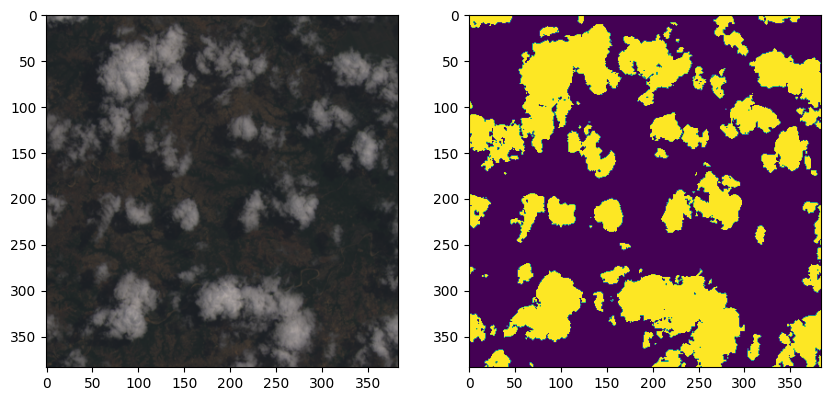

In [ ]:
# visualize raw image and ground truth
image_index = 10

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))


In [ ]:
from skimage import io
import numpy as np

def iou_metric(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    intersection = np.sum(pred_mask * true_mask)
    union = np.sum((pred_mask + true_mask) > 0)

    iou = intersection / union

    return iou

# Carregar imagem prevista e verdadeira
pred_image_path = "/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384/patch_329_17_by_9_LC08_L1TP_002053_20160520_20170324_01_T1.TIF"

pred_image = io.imread(pred_image_path)

iou = iou_metric(pred_image, data.open_mask(image_index))
print("IoU:", iou)


IoU: 0.919060322187067


In [ ]:
from skimage import io
import numpy as np
import os

def dice_coefficient(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    intersection = np.sum(pred_mask * true_mask)
    dice_coeff = (2 * intersection) / (np.sum(pred_mask) + np.sum(true_mask) + 1e-7)

    return dice_coeff

def accuracy(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    correct_pixels = np.sum(pred_mask == true_mask)
    total_pixels = pred_mask.size

    accuracy = correct_pixels / total_pixels

    return accuracy

def precision(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    true_positives = np.sum(pred_mask * true_mask)
    false_positives = np.sum(pred_mask * (1 - true_mask))

    precision = true_positives / (true_positives + false_positives + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return precision

def recall(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    true_positives = np.sum(pred_mask * true_mask)
    false_negatives = np.sum((1 - pred_mask) * true_mask)

    recall = true_positives / (true_positives + false_negatives + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return recall

def f1_score(pred_mask, true_mask, threshold=0.5):
    prec = precision(pred_mask, true_mask, threshold)
    rec = recall(pred_mask, true_mask, threshold)

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)  # adicionando pequena constante para evitar divisão por zero

    return f1

def iou_metric(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask = (true_mask > 0.5).astype(np.float32)

    intersection = np.sum(pred_mask * true_mask)
    union = np.sum((pred_mask + true_mask) > 0)

    iou = intersection / (union + 1e-7)

    return iou

def evaluate_metrics(pred_mask, true_mask):
    dice = dice_coefficient(pred_mask, true_mask)
    acc = accuracy(pred_mask, true_mask)
    prec = precision(pred_mask, true_mask)
    rec = recall(pred_mask, true_mask)
    f1 = f1_score(pred_mask, true_mask)
    iou = iou_metric(pred_mask, true_mask)
    return dice, acc, prec, rec, f1, iou

def calculate_metrics_in_directory(pred_folder, true_folder, threshold=0.5):
    dice_scores = []
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    iou_scores = []

    pred_images = os.listdir(pred_folder)
    true_images = os.listdir(true_folder)

    for pred_img_name in pred_images:
      true_img_name = "gt_"+pred_img_name
      pred_img_path = os.path.join(pred_folder, pred_img_name)
      true_img_path = os.path.join(true_folder, true_img_name)

      pred_image = io.imread(pred_img_path)
      true_image = io.imread(true_img_path)

      dice, acc, prec, rec, f1, iou = evaluate_metrics(pred_image, true_image)

      dice_scores.append(dice)
      acc_scores.append(acc)
      prec_scores.append(prec)
      rec_scores.append(rec)
      f1_scores.append(f1)
      iou_scores.append(iou)

    mean_dice = np.mean(dice_scores)
    mean_acc = np.mean(acc_scores)
    mean_prec = np.mean(prec_scores)
    mean_rec = np.mean(rec_scores)
    mean_f1 = np.mean(f1_scores)
    mean_iou = np.mean(iou_scores)

    return mean_dice, mean_acc, mean_prec, mean_rec, mean_f1, mean_iou

# Substitua 'caminho_para_pred' e 'caminho_para_true' pelos caminhos reais do seu diretório
caminho_para_pred = "/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384/"
caminho_para_true = "/content/data/teste/test_gt"

mean_dice, mean_acc, mean_prec, mean_rec, mean_f1, mean_iou = calculate_metrics_in_directory(caminho_para_pred, caminho_para_true)

print("Mean Dice Coefficient:", mean_dice)
print("Mean Accuracy:", mean_acc)
print("Mean Precision:", mean_prec)
print("Mean Recall:", mean_rec)
print("Mean F1 Score:", mean_f1)
print("Mean IoU:", mean_iou)


Mean Dice Coefficient: 0.4791157126732166
Mean Accuracy: 0.8564950992431422
Mean Precision: 0.5565194238050918
Mean Recall: 0.48226140088783576
Mean F1 Score: 0.4791156856965232
Mean IoU: 0.44272508149155176


In [ ]:
xb, yb = data[10]
xb.shape, yb.shape

(torch.Size([3, 384, 384]), torch.Size([384, 384]))

In [ ]:
def predb_to_mask_(predb):
    p = torch.functional.F.softmax(predb)
    return p.argmax(0).cpu()

### predições

In [ ]:
from ultralytics import YOLO

In [ ]:
def iou_metric(predb, yb, threshold=0.5):
    pred_mask = (predb > threshold).float()
    true_mask = (yb > threshold).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = intersection / union
    return iou

In [ ]:
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [ ]:
def calculate_iou_yolo(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

ue
unet:  0.6717163324356079
fpn:  0.556816041469574


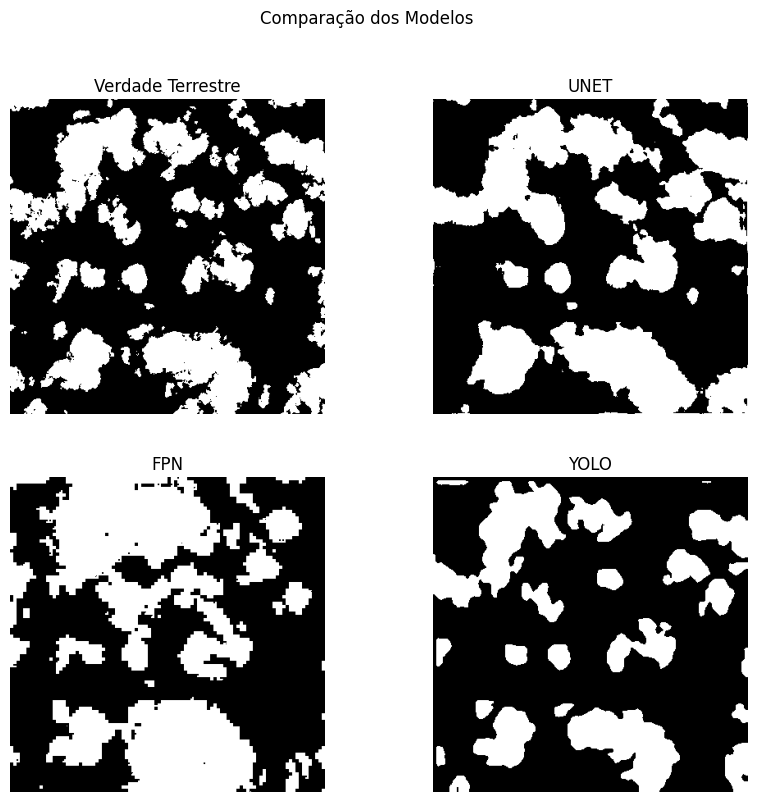

In [ ]:
xb, yb = data[10]

base_path = Path("/content/drive/MyDrive/TCC")

checkpoint = torch.load(base_path/"unet/best_Unet-NET_b32_e500_p35_lr0.001_i3_o2_epoch124EarlyStop.pth", map_location=torch.device('cpu'))
model_unet = UNET(config['IN_CHANEL'], config['OUT_CHANNEL'])
model_unet.load_state_dict(checkpoint)

checkpoint = torch.load(base_path/"fpn-net/best_FPN-NET_b32_e500_p35_lr0.001_i3_o2_epoch150.pth", map_location=torch.device('cpu'))
model_fpn = FPN(backbone='resnet18', num_classes=2, pretrained=False)
model_fpn.load_state_dict(checkpoint)

yolo_model = YOLO(base_path/"yolo/best_f.pt")


input_model = xb.unsqueeze(0)
with torch.no_grad():
    output_unet = model_unet(input_model)
    output_fpn_net = model_fpn(input_model)


image = data.open_as_array(image_index)
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
normalized_image = normalized_image.astype(np.uint8)

results = yolo_model(normalized_image, verbose=False)

# Carregar a imagem original
original_image = normalized_image

# Criar uma imagem em branco com as mesmas dimensões da original
mask_image = np.zeros_like(original_image)

for result in results:
    if result.masks is not None:
        print('ue')
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca


output_fpn_net = output_fpn_net.squeeze(0)
output_unet = output_unet.squeeze(0)


iou_unet = iou_metric(predb_to_mask_(output_unet.squeeze(0)), yb)
iou_fpn = iou_metric(predb_to_mask_(output_fpn_net.squeeze(0)), yb)

print('unet: ',iou_unet)
print('fpn: ',iou_fpn)


fig, ax = plt.subplots(2, 2, figsize=(10, 9))

# Ground Truth
ax[0, 0].imshow(yb, cmap='gray')
ax[0, 0].set_title('Verdade Terrestre')
ax[0, 0].axis('off')

# by UNET
ax[0, 1].imshow(predb_to_mask_(output_unet), cmap='gray')
ax[0, 1].set_title('UNET')
ax[0, 1].axis('off')

# Prediction by FPN
ax[1, 0].imshow(predb_to_mask_(output_fpn_net), cmap='gray')
ax[1, 0].set_title('FPN')
ax[1, 0].axis('off')

# Mask from YOLO
ax[1, 1].imshow(mask_image, cmap='gray')
ax[1, 1].set_title('YOLO')
ax[1, 1].axis('off')

# Adding a global title
fig.suptitle('Comparação dos Modelos')

plt.show()

In [ ]:
from ultralytics import YOLO

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

base_path = Path("/content/drive/MyDrive/TCC")
yolo_model = YOLO(base_path / "yolo/best_f.pt")

iou_values = []

# Iterar sobre o conjunto de dados de teste
for indice in valid_dataset.indices:
    xb, yb = data[indice]
    image = data.open_as_array(indice)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    normalized_image = normalized_image.astype(np.uint8)

    results = yolo_model(normalized_image, verbose=False)

    # Carregar a imagem original
    original_image = normalized_image

    # Criar uma imagem em branco com as mesmas dimensões da original
    mask_image = np.zeros_like(original_image)

    for result in results:
        if result.masks is not None:
            for mask, box in zip(result.masks.xy, result.boxes):
                points = np.int32([mask])
                cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca

    if np.any(mask_image):
        pred_mask = mask_image[..., 0] > 0
        yb = yb[0].numpy()  # yb[0] porque é um batch de 1
        iou_yolo = calculate_iou(pred_mask, yb)
        iou_values.append(iou_yolo)

    normalized_image = None
    image = None
    mask_image = None
    original_image = None

# Média das IoUs
mean_iou = np.mean(iou_values)
print("Mean IoU:", mean_iou)

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

xb, yb = data[10]

base_path = Path("/content/drive/MyDrive/TCC")

yolo_model = YOLO(base_path/"yolo/best_f.pt")

image = data.open_as_array(image_index)
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
normalized_image = normalized_image.astype(np.uint8)

results = yolo_model(normalized_image, verbose=False)

# Carregar a imagem original
original_image = normalized_image

# Criar uma imagem em branco com as mesmas dimensões da original
mask_image = np.zeros_like(original_image)

for result in results:
    if result.masks is not None:
        print('ue')
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca


if np.any(mask_image):
    pred_mask = mask_image[..., 0] > 0
    # Convert pred_mask and yb to numpy array
    pred_mask = pred_mask.cpu().numpy() if isinstance(pred_mask, torch.Tensor) else pred_mask
    yb = yb.cpu().numpy() if isinstance(yb, torch.Tensor) else yb
    print(yb.shape, pred_mask.shape)
    iou_yolo = calculate_iou(pred_mask, yb)
    print("IoU YOLO:", iou_yolo)


ue
(384, 384) (384, 384)
IoU YOLO: 0.7264099619174273


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from torchvision.transforms.functional import to_pil_image

def predb_to_mask_(predb):
    return torch.argmax(predb, dim=0)

# Suponha que a variável 'data' seja uma lista contendo imagens
# Suponha que a variável 'image_index' seja o índice da imagem que você quer usar
data = [Image.open("/content/data/Predictions/Cloud-Net_trained_on_38-Cloud_training_patches_train_192_test_384/patch_329_17_by_9_LC08_L1TP_002053_20160520_20170324_01_T1.TIF")]

xb, yb = data[10]

base_path = Path("/content/drive/MyDrive/TCC")

checkpoint = torch.load(base_path/"unet/best_Unet-NET_b32_e500_p35_lr0.001_i3_o2_epoch124EarlyStop.pth", map_location=torch.device('cpu'))
model_unet = UNET(config['IN_CHANEL'], config['OUT_CHANNEL'])
model_unet.load_state_dict(checkpoint)

checkpoint = torch.load(base_path/"fpn-net/best_FPN-NET_b32_e500_p35_lr0.001_i3_o2_epoch150.pth", map_location=torch.device('cpu'))
model_fpn = FPN(backbone='resnet18', num_classes=2, pretrained=False)
model_fpn.load_state_dict(checkpoint)

yolo_model = YOLO(base_path/"yolo/best_f.pt")


input_model = xb.unsqueeze(0)
with torch.no_grad():
    output_unet = model_unet(input_model)
    output_fpn_net = model_fpn(input_model)


image = data.open_as_array(image_index)
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
normalized_image = normalized_image.astype(np.uint8)

results = yolo_model(normalized_image, verbose=False)

# Carregar a imagem original
original_image = normalized_image

# Criar uma imagem em branco com as mesmas dimensões da original
mask_image = np.zeros_like(original_image)

for result in results:
    if result.masks is not None:
        print('ue')
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca


output_fpn_net = output_fpn_net.squeeze(0)
output_unet = output_unet.squeeze(0)

fig, ax = plt.subplots(2, 3, figsize=(15, 9))

# Ground Truth
ax[0, 0].imshow(yb, cmap='gray')
ax[0, 0].set_title('Verdade Terrestre')
ax[0, 0].axis('off')

# by UNET
ax[0, 1].imshow(predb_to_mask_(output_unet), cmap='gray')
ax[0, 1].set_title('UNET')
ax[0, 1].axis('off')

# Prediction by FPN
ax[1, 0].imshow(predb_to_mask_(output_fpn_net), cmap='gray')
ax[1, 0].set_title('FPN')
ax[1, 0].axis('off')

# Mask from YOLO
ax[1, 1].imshow(mask_image, cmap='gray')
ax[1, 1].set_title('YOLO')
ax[1, 1].axis('off')

# Add the tiff image
ax[0, 2].imshow(data[image_index], cmap='gray')
ax[0, 2].set_title('Tiff Image')
ax[0, 2].axis('off')

# Adding a global title
fig.suptitle('Comparação dos Modelos')

plt.show()


IndexError: list index out of range

In [ ]:
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2
from google.colab.patches import cv2_imshow

yolo_model = YOLO("/content/best_f.pt")


image_path = "/content/yolo/images/val/"
mask_path = os.path.join(image_path, "mask")

iou_scores = []
processed_images = 0

image = data.open_as_array(image_index)
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
normalized_image = normalized_image.astype(np.uint8)

results = yolo_model(normalized_image, verbose=False)

# Carregar a imagem original
original_image = normalized_image

# Criar uma imagem em branco com as mesmas dimensões da original
mask_image = np.zeros_like(original_image)

for result in results:
    if result.masks is not None:
        print('ue')
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv2.fillPoly(mask_image, [points], (255, 255, 255))  # Preencher a máscara com a cor branca

cv2_imshow(mask_image)




TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [ ]:
image_index=10
print(data.open_as_array(image_index).shape)
cv2.imwrite("teste_2.png", data.open_as_array(image_index))
fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))

NameError: name 'data' is not defined

In [ ]:
import cv2
import numpy as np

# Normalizar os valores dos pixels para o intervalo de 0 a 255
image = data.open_as_array(image_index)
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
normalized_image = normalized_image.astype(np.uint8)

# Salvar a imagem
cv2.imwrite("teste_2.png", normalized_image)


True

In [ ]:
cv2.imwrite("teste_1.png", data.open_as_array(image_index))

True

In [ ]:
import numpy as np
import cv2

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def precision_recall_f1(pred_mask, gt_mask, threshold=0.5):
    true_positives = np.sum(np.logical_and(pred_mask > threshold, gt_mask == 1))
    false_positives = np.sum(np.logical_and(pred_mask > threshold, gt_mask == 0))
    false_negatives = np.sum(np.logical_and(pred_mask <= threshold, gt_mask == 1))

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, f1_score

def overall_accuracy(pred_mask, gt_mask):
    total_pixels = np.prod(pred_mask.shape)
    correct_pixels = np.sum(pred_mask == gt_mask)
    overall_acc = correct_pixels / total_pixels
    return overall_acc

overall_accuracy_scores = []


dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

processed_images = 0

for filename in os.listdir(image_path):
    if filename.endswith(".png"):
        image_file = os.path.join(image_path, filename)
        results = yolo_model(image_file, verbose=False)

        original_image = cv2.imread(image_file)

        mask_image = np.zeros_like(original_image)

        for result in results:
            if result.masks is not None:
                for mask, box in zip(result.masks.xy, result.boxes):
                    points = np.int32([mask])
                    cv2.fillPoly(mask_image, [points], (255, 255, 255))

        if np.any(mask_image):
            pred_mask = mask_image[..., 0] > 0

            gt_mask_file = os.path.join(mask_path, filename)
            gt_mask_img = cv2.imread(gt_mask_file, cv2.IMREAD_GRAYSCALE)
            gt_mask = (gt_mask_img > 0).astype(np.uint8)

            iou = calculate_iou(pred_mask, gt_mask)
            dice = dice_coefficient(pred_mask, gt_mask)
            overall_acc = overall_accuracy(pred_mask, gt_mask)

            dice_scores.append(dice)
            iou_scores.append(iou)
            overall_accuracy_scores.append(overall_acc)

            precision, recall, f1_score = precision_recall_f1(pred_mask, gt_mask, threshold=0.6)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1_score)

        processed_images += 1
        if processed_images >= 100:
            break

mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1_score = np.mean(f1_scores)
mean_overall_accuracy = np.mean(overall_accuracy_scores)

print("Mean Dice Coefficient:", mean_dice)
print("Mean IoU:", mean_iou)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("overall acuracy: ", mean_overall_accuracy)


torch.Size([3, 384, 384])


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'
